<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: center; background-color:rgb(18, 135, 198); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>Table of Contents </b></h3>
    
- I. Crawling Data and Merging Datasets
- II. Exploring and Pre-processing Data
    - [2.1. Basic infomation](#2.1.)
        - [2.1.1. Shape of data](#2.1.1.)
        - [2.1.2. Meaning of each row](#2.1.2.)
        - [2.1.3. Meaning of each column](#2.1.3.)
        - [2.1.4. Check duplicate](#2.1.4.)
        - [2.1.5. Data type of each column (standardize if necessary)](#2.1.5.)
        - [2.1.6. Missing values of each column](#2.1.6)
    - [2.2 Data distribution](#2.2.)
        - [2.2.1. Numerical columns](#2.2.1.)
        - [2.2.2. Categorical columns](#2.2.2.)
    - [2.3. Abnormal values and outliers](#2.3.)
    - [2.4. Correlation between variables](#2.4)
- III. Asking meaningful questions

In [1]:
import os
import requests
from flask import Flask, session
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.cache_handler import CacheHandler
import base64
import ast

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
import time
import datetime
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import urllib

In [4]:
import pandas as pd
import numpy as np

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: center; background-color:rgb(2, 100, 153); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1. Crawling Data and Merging Datasets </b></h3>

<a class="anchor" id="1.1."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.1. Helper functions </b></h4>

In [5]:
def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    
    # Correct Base64 encoding
    credentials = f"{client_id}:{client_secret}".encode('utf-8')
    encoded_credentials = base64.b64encode(credentials).decode('utf-8')
    
    auth_header = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    auth_data = {
        'grant_type': 'client_credentials'
    }
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    
    if response.status_code == 200:
        data = response.json()
        return data['access_token']
    else:
        print("Error:", response.status_code, response.text)
        return None


In [6]:
def refresh_access_token(client_id, client_secret, refresh_token):
    auth_url = 'https://accounts.spotify.com/api/token'
    
    # Correct Base64 encoding
    credentials = f"{client_id}:{client_secret}".encode('utf-8')
    encoded_credentials = base64.b64encode(credentials).decode('utf-8')
    
    auth_header = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    auth_data = {
        'grant_type': 'refresh_token',
        'refresh_token': refresh_token
    }
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    
    if response.status_code == 200:
        data = response.json()
        return data['access_token']
    
    else:
        print("Error:", response.status_code, response.text)
        return None
    

<a class="anchor" id="1.2."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.2. Define necessary params for authentication </b></h4>


In [7]:
client_id = "dbdd996b41794e00a9147d472d3b8ab2"
client_secret = "d5cc548e8c2f4d50b7e5b61fa75846af"
redirect_uri = "http://localhost:3000/callback"
# scope = "user-library-read"

In [8]:
auth_url = "https://accounts.spotify.com/authorize"
auth_params = {
    "client_id": client_id,
    "response_type": "code",
    "redirect_uri": redirect_uri,
    # "scope": scope
}

authorization_url = f"{auth_url}?{urllib.parse.urlencode(auth_params)}"
print("Go to the following URL to authorize the application:")
print(authorization_url)

Go to the following URL to authorize the application:
https://accounts.spotify.com/authorize?client_id=dbdd996b41794e00a9147d472d3b8ab2&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A3000%2Fcallback


In [9]:
# Step 2: After the user authorizes the application, they will be redirected to the redirect_uri with a code parameter
# You need to capture that code parameter and use it to obtain an access token and refresh token

# For demonstration purposes, let's assume you have obtained the authorization code
authorization_code = input("Enter the authorization code: ")

# Step 3: Exchange the authorization code for an access token and refresh token
token_url = "https://accounts.spotify.com/api/token"
credentials = f"{client_id}:{client_secret}".encode('utf-8')
encoded_credentials = base64.b64encode(credentials).decode('utf-8')

token_headers = {
    "Authorization": f"Basic {encoded_credentials}",
    "Content-Type": "application/x-www-form-urlencoded"
}

token_data = {
    "grant_type": "authorization_code",
    "code": authorization_code,
    "redirect_uri": redirect_uri
}

response = requests.post(token_url, headers=token_headers, data=token_data)

if response.status_code == 200:
    data = response.json()
    access_token = data["access_token"]
    refresh_token = data["refresh_token"]
    print("Access Token:", access_token)
    print("Refresh Token:", refresh_token)
else:
    print("Error:", response.status_code, response.text)

# Step 4: Use the refresh token to obtain a new access token
def refresh_access_token(client_id, client_secret, refresh_token):
    auth_url = 'https://accounts.spotify.com/api/token'
    
    credentials = f"{client_id}:{client_secret}".encode('utf-8')
    encoded_credentials = base64.b64encode(credentials).decode('utf-8')
    
    auth_header = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    auth_data = {
        'grant_type': 'refresh_token',
        'refresh_token': refresh_token
    }
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    
    if response.status_code == 200:
        data = response.json()
        return data['access_token']
    else:
        print("Error:", response.status_code, response.text)
        return None

# Use the refresh token to get a new access token
new_access_token = refresh_access_token(client_id, client_secret, refresh_token)
print("New Access Token:", new_access_token)

Access Token: BQBKde10MRX_2PNyYvb4sV7ZSNV49FNg6VYgEwdvzsR2mF3Ei4D7QREm0rJTod-BTZex_bmQtwSMhY9W6cb52rxo-CU5-Ej1bO_gvyzS4XYS228JTMPrfAH4Y8nyUlxUFqPLtBYCNvzHlD7s35qF-vHSXTdxDqmezyDpl5oadRXrz-ufgSn-B7Wf6o6DbiyK2ZsuqZAV_AWJ_8MQyUoDXOr1r4Vo4S5Cq4O5-A
Refresh Token: AQDjM9wF0hYXhSqxs-OL6HnRO3KwreQadh9pNE_Jix_K9xHvKlCkNw5GfOhKWC3JZwj-b_IN4-vDqRE1lfOmzQBZxqS5xwIig-h_37Jkd1tT-C_KTzwdAZO09wdXmCXjqnA
New Access Token: BQBCHC6Ggsmgj8nLh8XgPlX8_OC-uI0hySb0IAyG6MJLK56bsa5qAIHk1tsTVQW6OrblJK0ow32kRVuSNV5jwJVBHAWWxxTHB5t0KhU8za96fw9U2pTjWzChJurl_qtW-G2-6ubtVdBkinomkqb-pN107nqNYNlN1D6pOShyjqr4gIZtyxrYP6zh5JwyuXSX2A2AW8w3tppo3hgnMrYW44mPMTaORioXdqpQMg


In [10]:
new_access_token
sp = spotipy.Spotify(auth=new_access_token)

<a class="anchor" id="1.3."></a>
<div class="list-group" id="list-tab" role="tablist">
    <h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.3. Crawl songs by market only </b></h4>


In [ ]:
def get_vietnamese_songs(query, limit_per_request=50, total_songs=3000, market="VN", min_popularity=50):
    all_tracks = []
    track_ids = set()
    offset = 0

    while len(all_tracks) < total_songs:
        try:
            results = sp.search(q=query, limit=limit_per_request, offset=offset, type='track', market=market)

            tracks = results.get('tracks', {}).get('items', [])
            if not tracks:  # Stop if no more tracks are found
                break

            for track in tracks:
                if track['id'] in track_ids:
                    continue  # Skip if the track is already in the dataset

                if track['popularity'] < min_popularity:
                    continue  # Skip tracks that are not popular enough

                album_id = track['album']['id'] if 'album' in track else None
                album_details = sp.album(album_id) if album_id else {}
                genres = album_details.get('genres', [])
                available_markets = album_details.get('available_markets', [])
                album_popularity = album_details.get('popularity', None)
                artist_genres = [genre for artist in track['artists'] for genre in artist.get('genres', [])]
                all_tracks.append({
                    'album': track['album']['name'], 
                    'album_type': track['album']['album_type'],
                    'album_popularity': album_popularity,
                    'artists': [artist['name'] for artist in track['artists']], 
                    'available_markets': available_markets, 
                    'disc_number': track['disc_number'], 
                    'duration_ms': track['duration_ms'],
                    'explicit': track['explicit'], 
                    'id': track['id'], 
                    'is_local': track['is_local'],
                    'is_playable': track.get('is_playable', False), 
                    'name': track['name'], 
                    'popularity': track['popularity'], 
                    'track_number': track['track_number'],
                    'type': track['type'], 
                    'genres': genres,  # Now using album genres
                    'release_date': track['album']['release_date'],
                    'artist_genres': artist_genres
                })

                track_ids.add(track['id'])  # Add track ID to the set

            offset += limit_per_request
            print(f"Fetched {len(all_tracks)} songs so far...")

            # Avoid hitting rate limits
            time.sleep(2)

        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 1))
                print(f"Rate limit exceeded. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                print(f"Error: {e}")
                break  # Stop execution on critical errors

    return all_tracks

years = range(2020, 2025)
vietnamese_songs = []

for year in years:
    query = f"year:{year}"  # Corrected query format
    vietnamese_songs.extend(get_vietnamese_songs(query=query, total_songs=1000, min_popularity=1))

print(f"Total Vietnamese songs collected: {len(vietnamese_songs)}")

In [19]:
df = pd.DataFrame(vietnamese_songs)

In [20]:
df

,album,album_type,album_popularity,artists,available_markets,disc_number,duration_ms,explicit,id,is_local,is_playable,name,popularity,track_number,type,genres,release_date
0,Đi Về Nhà,single,50,"[Đen, JustaTee]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,200000,False,7LVrrX8pkzI9fMF88nGabt,False,True,Đi Về Nhà,61,1,track,[],2020-12-20
1,CUA,single,40,"[MANBO, HIEUTHUHAI]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,193475,True,0ReId5SRMspb6ISw0rBsBN,False,True,CUA,50,1,track,[],2020-04-05
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"[MANBO, HIEUTHUHAI, HURRYKNG]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,222000,False,0s7RyyUlQfd8mnnboHe18n,False,True,Hẹn Gặp Em Dưới Ánh Trăng,63,1,track,[],2020-09-25
3,Still With You,single,64,[Jung Kook],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,239905,False,0eFMbKCRw8KByXyWBw8WO7,False,True,Still With You,75,1,track,[],2020-06-05
4,HELP EVER HURT NEVER,album,65,[Fujii Kaze],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,185573,False,0o9zmvc5f3EFApU52PPIyW,False,True,Shinunoga E-Wa,74,8,track,[],2020-05-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,külm,single,31,[An-Marlen],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,176200,False,1M00EDfnI8zrf0clHUSJY6,False,True,külm,42,1,track,[],2024-12-06
4856,SUEÑO MAGNIFICO,single,48,[Najm],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,136968,True,6x4eiL3u5iWWDVumT8JSqd,False,True,LOTSOFLOVE,51,4,track,[],2024-09-05
4857,Alleen Met Jou,single,56,"[Yves Berendse, Emma Heesters]","[AR, AU, AT, BO, BR, BG, CA, CL, CO, CR, CY, C...",1,193694,False,2K7HqkHEUfz7c4BzEO33Qd,False,True,Alleen Met Jou,66,1,track,[],2024-09-27
4858,TUTTA VITA,album,72,"[Olly, JVLI]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,190122,False,1ej2NcW0CHnscPp1RZpr1V,False,True,Devastante,68,6,track,[],2024-10-25


In [21]:
# Check for duplicates
df.duplicated(subset=['id']).sum()

np.int64(0)

In [ ]:
# # Check number of unique values in available_markets
# df['available_markets'] = df['available_markets'].apply(len)
# df['available_markets'].value_counts()

In [ ]:
df['genres'] = df['genres'].apply(lambda x: ', '.join(x) if x else None)
df['genres'].value_counts()

Series([], Name: count, dtype: int64)

In [32]:
df['album_popularity'].unique()

array([50, 40, 53, 64, 65, 66, 54, 41, 83, 74, 71, 47, 42, 67, 45, 75, 44,
       46, 43, 39, 49, 68, 79, 82, 72, 69, 58, 60, 63, 48, 70, 76, 77, 56,
       57, 73, 62, 61, 55, 59, 78, 38, 52, 51, 32, 33, 36, 37, 35, 80, 31,
       28, 34, 30, 26, 27, 29, 25, 20, 85, 81, 86, 24, 87, 23, 84, 88, 92,
       89])

In [24]:
df.to_csv('data/vietnamese_songs.csv', index=False)

<a class="anchor" id="1.4."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.4. Crawl songs by Vietnamese artists </b></h4>



In [ ]:
def get_song_by_artist(artist_name, limit_per_request=50, total_songs=50):
    all_tracks = []
    track_ids = set()
    offset = 0
    batch_size = 20 
    album_cache = {} 
    artist_cache = {} 

    print("Fetching song for artist: ", artist_name)
    while len(all_tracks) < total_songs:
        try:
            results = sp.search(q=f"artist:{artist_name}", limit=limit_per_request, offset=offset, type='track', market = 'VN')
            tracks = results.get('tracks', {}).get('items', [])

            if not tracks:  
                break 

            album_ids = {track['album']['id'] for track in tracks if 'album' in track}  
            new_album_ids = album_ids - album_cache.keys()
            artist_ids = {artist['id'] for track in tracks for artist in track.get('artists', []) if 'id' in artist}
            new_artist_ids = artist_ids - artist_cache.keys()

            for i in range(0, len(new_album_ids), batch_size):
                album_batch = list(new_album_ids)[i:i + batch_size]
                album_results = sp.albums(album_batch)  
                for album in album_results.get('albums', []):
                    album_cache[album['id']] = {
                        'genres': album.get('genres', []),
                        'available_markets': album.get('available_markets', []),
                        'popularity': album.get('popularity', None),
                    }

            for i in range(0, len(new_artist_ids), 50):
                artist_batch = list(new_artist_ids)[i:i + 50]
                artist_results = sp.artists(artist_batch)
                for artist in artist_results.get('artists', []):
                    artist_cache[artist['id']] = artist.get('genres', [])  

            for track in tracks:
                if track['id'] in track_ids:
                    continue  

                album_info = album_cache.get(track['album']['id'], {})
                artist_names = [artist.get('name', 'Unknown Artist') for artist in track.get('artists', [])]
                artist_genres = set()  

                for artist in track.get('artists', []):
                    artist_genres.update(artist_cache.get(artist['id'], []))

                all_tracks.append({
                    'id': track['id'], 
                    'name': track.get('name', 'Unknown Track'), 
                    'artists': artist_names,
                    'album': track['album'].get('name', 'Unknown Album'), 
                    'album_type': track['album'].get('album_type', 'unknown'),
                    'album_popularity': album_info.get('popularity'),
                    'genres': list(artist_genres), 
                    'available_markets': album_info.get('available_markets', []), 
                    'track_number': track.get('track_number', 0),
                    'disc_number': track.get('disc_number', 0), 
                    'duration_ms': track.get('duration_ms', 0),
                    'popularity': track.get('popularity', 0), 
                    'release_date': track['album'].get('release_date', 'Unknown'),
                })

                track_ids.add(track['id'])  

            offset += limit_per_request
            print(f"Fetched {len(all_tracks)} songs so far...")

            if len(all_tracks) >= total_songs:
                break  

            time.sleep(1)  

        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 1))
                print(f"Rate limit exceeded. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                print(f"Error: {e}")
                break  

    return all_tracks


def get_vietnamese_songs(artists_list, total_songs=100, song_per_artist = 30):
    all_vietnamese_songs = []
    track_ids = set()
    for artist in artists_list:
        songs = get_song_by_artist(artist, total_songs=song_per_artist)  
        for song in songs:
            if song['id'] not in track_ids:
                all_vietnamese_songs.append(song)
                track_ids.add(song['id'])
        if len(all_vietnamese_songs) >= total_songs:
            break  
        time.sleep(1)  
    return all_vietnamese_songs


In [ ]:
genres = ['vinahouse', 'v-pop', 'vietnamese lo-fi', 'vietnam indie', 'vietnamese hip hop', 'vietnamese', 'vietnam', 'vietnamese bolero']

#Get vietnamese artist from these genre
def get_artists_for_genres(genres, limit_per_request=50, total_artists_per_genre = 100):
    
    all_artists = []
    artist_ids = set()

    for genre in genres:
        print(f"\nFetching artists for genre: {genre}")
        offset = 0
        genre_artists = []

        while len(genre_artists) < total_artists_per_genre:
            try:
                results = sp.search(q=f"genre:{genre}", type="artist", limit=limit_per_request, offset=offset)
                artists = results.get("artists", {}).get("items", [])

                if not artists:
                    print(f"No more artists found for {genre}.")
                    break  

                new_artists = [
                    artist for artist in artists 
                    if artist["id"] not in artist_ids
                ]

                for artist in new_artists[:total_artists_per_genre - len(genre_artists)]:
                    artist_info = {
                        "id": artist["id"],
                        "name": artist["name"],
                        "popularity": artist.get("popularity", 0),
                        "followers": artist["followers"].get("total", 0),
                        "genres": artist.get("genres", []),
                    }
                    genre_artists.append(artist_info)
                    artist_ids.add(artist["id"])

                offset += limit_per_request
                print(f"Fetched {len(genre_artists)} artists for {genre} so far...")

                time.sleep(1)

            except spotipy.exceptions.SpotifyException as e:
                if e.http_status == 429:
                    retry_after = int(e.headers.get("Retry-After", 1))
                    print(f"Rate limit exceeded. Retrying in {retry_after} seconds...")
                    time.sleep(retry_after)
                else:
                    print(f"Spotify API error: {e}")
                    break
            except Exception as e:
                print(f"Unexpected error: {e}")
                break

        all_artists.extend(genre_artists)

    return all_artists

In [ ]:
artists_df = get_artists_for_genres(genres=genres, limit_per_request=50, total_artists_per_genre=100)
artists_df = pd.DataFrame(artists_df)
artists_df.to_csv("data/vietnamese_artists.csv", index=False)


,id,name,popularity,followers,genres
0,08xn7sYY4KworP8Vc3GoiU,Orinn,55,558309,"['vinahouse', 'vietnamese lo-fi', 'v-pop', 'lo..."
1,0jF7Zlz8P5p74zcH7YwcMU,Anh Quân Idol,42,36965,"['vinahouse', 'vietnamese lo-fi', 'v-pop', 'lo..."
2,7MsHVZKh1TeKgGqm65kZnY,Vũ Duy Khánh,35,22264,"['vinahouse', 'v-pop', 'vietnamese bolero']"
3,7JpgJSzLFVxFcMIRUhq7vV,Lương Bích Hữu,36,27958,"['vinahouse', 'v-pop', 'vietnamese bolero', 'v..."
4,0okOBQvuWiPJnfvvmosphN,VIET.,35,24396,"['vinahouse', 'vietnamese lo-fi', 'v-pop']"
...,...,...,...,...,...
331,7vCKeEqgPv1FFEM2OivtNj,Ngọc Ngữ,27,2349,"['vietnamese bolero', 'bolero']"
332,5jAkbuyAcJlFqLH4z88ukv,Trần Thái Hoà,28,23977,"['vietnamese bolero', 'bolero']"
333,41eUMVb8BInRlwH1Cx6v3N,Lương Tùng Quang,28,9697,"['vietnamese bolero', 'v-pop']"
334,4oFMIlXAVelFtZxOEnc9EX,Châu Ngọc Hà,27,1795,"['vietnamese bolero', 'bolero']"


In [ ]:
artists_df = pd.read_csv("data/vietnamese_artists.csv")
artists_df = artists_df.sort_values('followers', ascending=False).reset_index(drop=True)
artists_df

,id,name,popularity,followers,genres
0,5dfZ5uSmzR7VQK0udbAVpf,Sơn Tùng M-TP,64,6425018,"['v-pop', 'vinahouse', 'vietnamese hip hop']"
1,1LEtM3AleYg1xabW6CRkpi,Đen,60,4255917,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
2,57g2v7gJZepcwsuwssIfZs,Vũ.,62,2357407,"['v-pop', 'vietnam indie', 'vietnamese lo-fi']"
3,5HZtdKfC4xU0wvhEyYDWiY,HIEUTHUHAI,67,2109280,"['v-pop', 'vietnamese hip hop', 'vietnamese lo..."
4,1CWwyDPjCowRTO4p6A7r6g,Mỹ Tâm,49,1974560,"['v-pop', 'vietnamese bolero', 'vietnam indie']"
...,...,...,...,...,...
331,6h54CyJrKz7VFTbhcNa5z5,Cao Sy Hung,2,155,['vinahouse']
332,63aNYEnei9zRJabFnVRQ3c,Mai Quốc Việt,0,135,['vinahouse']
333,7kuPvJW5dFp3jcDzbCJuCf,Nguyen Hai Yen,0,120,[]
334,22Cg030HR9Ytnyc1uJ11rO,Hàn Khởi,4,115,"['vinahouse', 'v-pop']"


In [ ]:
def reformat_name(name):
    return unidecode(name)

artists_df['reformated name'] = artists_df['name'].apply(reformat_name)

artists_df

,id,name,popularity,followers,genres,reformated name
0,5dfZ5uSmzR7VQK0udbAVpf,Sơn Tùng M-TP,64,6425018,"['v-pop', 'vinahouse', 'vietnamese hip hop']",Son Tung M-TP
1,1LEtM3AleYg1xabW6CRkpi,Đen,60,4255917,"['v-pop', 'vietnamese hip hop', 'vietnam indie...",Den
2,57g2v7gJZepcwsuwssIfZs,Vũ.,62,2357407,"['v-pop', 'vietnam indie', 'vietnamese lo-fi']",Vu.
3,5HZtdKfC4xU0wvhEyYDWiY,HIEUTHUHAI,67,2109280,"['v-pop', 'vietnamese hip hop', 'vietnamese lo...",HIEUTHUHAI
4,1CWwyDPjCowRTO4p6A7r6g,Mỹ Tâm,49,1974560,"['v-pop', 'vietnamese bolero', 'vietnam indie']",My Tam
...,...,...,...,...,...,...
331,6h54CyJrKz7VFTbhcNa5z5,Cao Sy Hung,2,155,['vinahouse'],Cao Sy Hung
332,63aNYEnei9zRJabFnVRQ3c,Mai Quốc Việt,0,135,['vinahouse'],Mai Quoc Viet
333,7kuPvJW5dFp3jcDzbCJuCf,Nguyen Hai Yen,0,120,[],Nguyen Hai Yen
334,22Cg030HR9Ytnyc1uJ11rO,Hàn Khởi,4,115,"['vinahouse', 'v-pop']",Han Khoi


In [ ]:
song_df = get_vietnamese_songs(artists_list=artists_df['reformated name'], total_songs=5000, song_per_artist=50)

song_df = pd.DataFrame(song_df)
song_df.to_csv("data/songs_2.csv", index=False)
song_df

Fetching song for artist:  Son Tung M-TP
Fetched 50 songs so far...
Fetching song for artist:  Den
Fetched 50 songs so far...
Fetching song for artist:  Vu.
Fetched 50 songs so far...
Fetching song for artist:  HIEUTHUHAI
Fetched 50 songs so far...
Fetching song for artist:  My Tam
Fetched 50 songs so far...
Fetching song for artist:  RAP VIET
Fetched 50 songs so far...
Fetching song for artist:  Low G
Fetched 50 songs so far...
Fetching song for artist:  W/N
Fetched 50 songs so far...
Fetching song for artist:  AMEE
Fetched 50 songs so far...
Fetching song for artist:  tlinh
Fetched 50 songs so far...
Fetching song for artist:  Duc Phuc
Fetched 50 songs so far...
Fetching song for artist:  Ha Anh Tuan
Fetched 50 songs so far...
Fetching song for artist:  Bich Phuong
Fetched 50 songs so far...
Fetching song for artist:  Binz
Fetched 50 songs so far...
Fetching song for artist:  RPT MCK
Fetched 50 songs so far...
Fetching song for artist:  Da LAB
Fetched 50 songs so far...
Fetching song

,id,name,artists,album,album_type,album_popularity,genres,available_markets,track_number,disc_number,duration_ms,popularity,release_date
0,31VNCmwspR7nVJ6kruUuJt,Đừng Làm Trái Tim Anh Đau,[Sơn Tùng M-TP],Đừng Làm Trái Tim Anh Đau,single,55,"[v-pop, vinahouse, vietnamese hip hop]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,279208,64,2024-06-08
1,2wZAvkgiOE5tyrnqhB69KA,Âm Thầm Bên Em,[Sơn Tùng M-TP],m-tp M-TP,album,62,"[v-pop, vinahouse, vietnamese hip hop]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",11,1,293112,60,2017-04-01
2,3OVMe3H6iAxbLF8iD2UYrw,Chúng Ta Của Tương Lai,[Sơn Tùng M-TP],Chúng Ta Của Tương Lai,single,50,"[v-pop, vinahouse, vietnamese hip hop]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,249871,60,2024-03-08
3,4vfhartd7HDWGJbdVIycEu,Muộn Rồi Mà Sao Còn,[Sơn Tùng M-TP],Muộn Rồi Mà Sao Còn,single,48,"[v-pop, vinahouse, vietnamese hip hop]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,275905,58,2021-04-29
4,1J3SmWwlYAG68LGKr86MVH,Chúng Ta Của Hiện Tại,[Sơn Tùng M-TP],Chúng Ta Của Hiện Tại,single,49,"[v-pop, vinahouse, vietnamese hip hop]","[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,301538,59,2020-12-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,1SclLzmq4d95cLJu0plLP5,God Grace,[Liu.G],God Grace,single,0,[],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,201325,0,2023-01-22
4999,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),[Steve S. Liu],Amazing Grace (Music Box Version),single,0,[],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,1,183760,0,2023-10-31
5000,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,[Jingyi Liu],Moonlight Falls,album,0,[],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",11,1,94560,0,2024-12-20
5001,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,[Samuel Liu],Undiscovered Land,album,0,[],"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",8,1,1315680,0,2019-01-24


In [ ]:
song_df = pd.read_csv("data/songs_2.csv")
song_df

,id,name,artists,album,album_type,album_popularity,genres,available_markets,track_number,disc_number,duration_ms,popularity,release_date
0,31VNCmwspR7nVJ6kruUuJt,Đừng Làm Trái Tim Anh Đau,['Sơn Tùng M-TP'],Đừng Làm Trái Tim Anh Đau,single,55,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,279208,64,2024-06-08
1,2wZAvkgiOE5tyrnqhB69KA,Âm Thầm Bên Em,['Sơn Tùng M-TP'],m-tp M-TP,album,62,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,293112,60,2017-04-01
2,3OVMe3H6iAxbLF8iD2UYrw,Chúng Ta Của Tương Lai,['Sơn Tùng M-TP'],Chúng Ta Của Tương Lai,single,50,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,249871,60,2024-03-08
3,4vfhartd7HDWGJbdVIycEu,Muộn Rồi Mà Sao Còn,['Sơn Tùng M-TP'],Muộn Rồi Mà Sao Còn,single,48,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,275905,58,2021-04-29
4,1J3SmWwlYAG68LGKr86MVH,Chúng Ta Của Hiện Tại,['Sơn Tùng M-TP'],Chúng Ta Của Hiện Tại,single,49,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,301538,59,2020-12-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,1SclLzmq4d95cLJu0plLP5,God Grace,['Liu.G'],God Grace,single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,201325,0,2023-01-22
4999,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),['Steve S. Liu'],Amazing Grace (Music Box Version),single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,183760,0,2023-10-31
5000,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,['Jingyi Liu'],Moonlight Falls,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,94560,0,2024-12-20
5001,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,['Samuel Liu'],Undiscovered Land,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",8,1,1315680,0,2019-01-24


<a class="anchor" id="1.5."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.5. Get the missing features </b></h4>

In [8]:
songs_2 = pd.read_csv('data/songs_2.csv')

In [9]:
songs_2

,id,name,artists,album,album_type,album_popularity,genres,available_markets,track_number,disc_number,duration_ms,popularity,release_date
0,31VNCmwspR7nVJ6kruUuJt,Đừng Làm Trái Tim Anh Đau,['Sơn Tùng M-TP'],Đừng Làm Trái Tim Anh Đau,single,55,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,279208,64,2024-06-08
1,2wZAvkgiOE5tyrnqhB69KA,Âm Thầm Bên Em,['Sơn Tùng M-TP'],m-tp M-TP,album,62,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,293112,60,2017-04-01
2,3OVMe3H6iAxbLF8iD2UYrw,Chúng Ta Của Tương Lai,['Sơn Tùng M-TP'],Chúng Ta Của Tương Lai,single,50,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,249871,60,2024-03-08
3,4vfhartd7HDWGJbdVIycEu,Muộn Rồi Mà Sao Còn,['Sơn Tùng M-TP'],Muộn Rồi Mà Sao Còn,single,48,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,275905,58,2021-04-29
4,1J3SmWwlYAG68LGKr86MVH,Chúng Ta Của Hiện Tại,['Sơn Tùng M-TP'],Chúng Ta Của Hiện Tại,single,49,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,301538,59,2020-12-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,1SclLzmq4d95cLJu0plLP5,God Grace,['Liu.G'],God Grace,single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,201325,0,2023-01-22
4999,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),['Steve S. Liu'],Amazing Grace (Music Box Version),single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,183760,0,2023-10-31
5000,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,['Jingyi Liu'],Moonlight Falls,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,94560,0,2024-12-20
5001,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,['Samuel Liu'],Undiscovered Land,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",8,1,1315680,0,2019-01-24


In [12]:
client_id = "b80f2ca2255d4d16b0fc73ce82aadb24"
client_secret = "322a7883a70f453cabf30401b04f66ca"
redirect_uri = "http://localhost:3000/callback"

In [18]:
auth_url = "https://accounts.spotify.com/authorize"

auth_params = {
    "client_id": client_id,
    "response_type": "code",
    "redirect_uri": redirect_uri,
    # "scope": scope
}

authorization_url = f"{auth_url}?{urllib.parse.urlencode(auth_params)}"
print("Go to the following URL to authorize the application:")
print(authorization_url)

Go to the following URL to authorize the application:
https://accounts.spotify.com/authorize?client_id=b80f2ca2255d4d16b0fc73ce82aadb24&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A3000%2Fcallback


In [45]:
authorization_code = input("Enter the authorization code: ")

# Step 3: Exchange the authorization code for an access token and refresh token
token_url = "https://accounts.spotify.com/api/token"
credentials = f"{client_id}:{client_secret}".encode('utf-8')
encoded_credentials = base64.b64encode(credentials).decode('utf-8')

token_headers = {
    "Authorization": f"Basic {encoded_credentials}",
    "Content-Type": "application/x-www-form-urlencoded"
}

token_data = {
    "grant_type": "authorization_code",
    "code": authorization_code,
    "redirect_uri": redirect_uri
}

response = requests.post(token_url, headers=token_headers, data=token_data)

if response.status_code == 200:
    data = response.json()
    access_token = data["access_token"]
    refresh_token = data["refresh_token"]
    print("Access Token:", access_token)
    print("Refresh Token:", refresh_token)
else:
    print("Error:", response.status_code, response.text)

# Step 4: Use the refresh token to obtain a new access token
def refresh_access_token(client_id, client_secret, refresh_token):
    auth_url = 'https://accounts.spotify.com/api/token'
    
    credentials = f"{client_id}:{client_secret}".encode('utf-8')
    encoded_credentials = base64.b64encode(credentials).decode('utf-8')
    
    auth_header = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    auth_data = {
        'grant_type': 'refresh_token',
        'refresh_token': refresh_token
    }
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    
    if response.status_code == 200:
        data = response.json()
        return data['access_token']
    else:
        print("Error:", response.status_code, response.text)
        return None

# Use the refresh token to get a new access token
new_access_token = refresh_access_token(client_id, client_secret, refresh_token)
print("New Access Token:", new_access_token)

Error: 400 {"error":"invalid_client","error_description":"Invalid client"}
New Access Token: BQAAoKt3k1vQMYmWCyZgYF0jdjRqfbP2FRUc4Kc6BRNRECdviFiAGjvnkwTmpcuKXFDGuhJ-_bi7eomFmdTYAaYSLkdFkHE9CdC5UCWQD8G2QKtphwsTFlLF1ZXn4VYOSeDhjjHbPacQihwNQpuMni0SMjNRWeTTLyXGTKfWYzEz-XXbDKq_ZO8mu_G3OrEZz8JKZVHrtMBvfv1XdTwr6D-N9mSfXCAPPk0h4Q


In [46]:
new_access_token
sp = spotipy.Spotify(auth=new_access_token)

In [17]:

# Get the is_explicit field for each song
def get_explicit_field(track_id):
    track = sp.track(track_id)
    return track.get('explicit', None)

In [18]:
for i, row in songs_2.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 1 with ID 31VNCmwspR7nVJ6kruUuJt...
Explicit: False

Processing song 2 with ID 2wZAvkgiOE5tyrnqhB69KA...
Explicit: False

Processing song 3 with ID 3OVMe3H6iAxbLF8iD2UYrw...
Explicit: False

Processing song 4 with ID 4vfhartd7HDWGJbdVIycEu...
Explicit: False

Processing song 5 with ID 1J3SmWwlYAG68LGKr86MVH...
Explicit: False

Processing song 6 with ID 7ESH2ntyD5Bb1XckoJU554...
Explicit: False

Processing song 7 with ID 5rSAUmbOg4giDrM29vUyHe...
Explicit: False

Processing song 8 with ID 3P3rcI48wwVEgxF5vPM6pG...
Explicit: False

Processing song 9 with ID 6aaNsCMWPBaUuJE1grH6Po...
Explicit: False

Processing song 10 with ID 7bn8ckDTI4EQIKZ6jRL4K0...
Explicit: False

Processing song 11 with ID 4SqE2XLtd1AfppGm2xlkf4...
Explicit: False

Processing song 12 with ID 527UV7H9SbnmTVkxBVg56X...
Explicit: False

Processing song 13 with ID 0tyrLp1zVAjN3EV95EuOzQ...
Explicit: False

Processing song 14 with ID 0tPBIwb0p5mozyF6GZVTUG...
Explicit: False

Processing song 15 with ID 4Q

KeyboardInterrupt: 

In [19]:
songs_2

,id,name,artists,album,album_type,album_popularity,genres,available_markets,track_number,disc_number,duration_ms,popularity,release_date,explicit
0,31VNCmwspR7nVJ6kruUuJt,Đừng Làm Trái Tim Anh Đau,['Sơn Tùng M-TP'],Đừng Làm Trái Tim Anh Đau,single,55,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,279208,64,2024-06-08,False
1,2wZAvkgiOE5tyrnqhB69KA,Âm Thầm Bên Em,['Sơn Tùng M-TP'],m-tp M-TP,album,62,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,293112,60,2017-04-01,False
2,3OVMe3H6iAxbLF8iD2UYrw,Chúng Ta Của Tương Lai,['Sơn Tùng M-TP'],Chúng Ta Của Tương Lai,single,50,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,249871,60,2024-03-08,False
3,4vfhartd7HDWGJbdVIycEu,Muộn Rồi Mà Sao Còn,['Sơn Tùng M-TP'],Muộn Rồi Mà Sao Còn,single,48,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,275905,58,2021-04-29,False
4,1J3SmWwlYAG68LGKr86MVH,Chúng Ta Của Hiện Tại,['Sơn Tùng M-TP'],Chúng Ta Của Hiện Tại,single,49,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,301538,59,2020-12-20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,1SclLzmq4d95cLJu0plLP5,God Grace,['Liu.G'],God Grace,single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,201325,0,2023-01-22,NaN
4999,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),['Steve S. Liu'],Amazing Grace (Music Box Version),single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,183760,0,2023-10-31,NaN
5000,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,['Jingyi Liu'],Moonlight Falls,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,94560,0,2024-12-20,NaN
5001,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,['Samuel Liu'],Undiscovered Land,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",8,1,1315680,0,2019-01-24,NaN


In [20]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [21]:
# Get the explicit of the next 1000 songs
songs_3 = songs_2[1002:2000].copy()

for i, row in songs_3.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)
    

Processing song 1003 with ID 6lNfj1VcaETCDfCuZJYj8I...
Explicit: False

Processing song 1004 with ID 49ykh7nLxxHkClY4wHFOt7...
Explicit: False

Processing song 1005 with ID 6F1ALV5RXd2Ghs7CNwYC6G...
Explicit: False

Processing song 1006 with ID 6xNed18guKRAOZMkvlxFA5...
Explicit: False

Processing song 1007 with ID 4z5dAyLMnkKSHkOkwbR1RX...
Explicit: False

Processing song 1008 with ID 4t8klWlToxvwHeXXA8SYpY...
Explicit: False

Processing song 1009 with ID 6d2SdcllPos7HflN5rXk76...
Explicit: False

Processing song 1010 with ID 1PgMKkHb6w1RdGhocmXS4d...
Explicit: False

Processing song 1011 with ID 7LqVJ4B2WlnfoMfNKRIJuq...
Explicit: False

Processing song 1012 with ID 6omqlTpk0xulezHygipOZx...
Explicit: False

Processing song 1013 with ID 3HCdFONw2wvrRsvJ5mcEDC...
Explicit: False

Processing song 1014 with ID 77agb6K1CMrwvTpC4k03Fm...
Explicit: False

Processing song 1015 with ID 31rqWdQbjz8x3JobYD1D5C...
Explicit: False

Processing song 1016 with ID 2NARD133RyXhJFMJIlgm7Y...
Explicit:

In [23]:
songs_2

,id,name,artists,album,album_type,album_popularity,genres,available_markets,track_number,disc_number,duration_ms,popularity,release_date,explicit
0,31VNCmwspR7nVJ6kruUuJt,Đừng Làm Trái Tim Anh Đau,['Sơn Tùng M-TP'],Đừng Làm Trái Tim Anh Đau,single,55,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,279208,64,2024-06-08,False
1,2wZAvkgiOE5tyrnqhB69KA,Âm Thầm Bên Em,['Sơn Tùng M-TP'],m-tp M-TP,album,62,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,293112,60,2017-04-01,False
2,3OVMe3H6iAxbLF8iD2UYrw,Chúng Ta Của Tương Lai,['Sơn Tùng M-TP'],Chúng Ta Của Tương Lai,single,50,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,249871,60,2024-03-08,False
3,4vfhartd7HDWGJbdVIycEu,Muộn Rồi Mà Sao Còn,['Sơn Tùng M-TP'],Muộn Rồi Mà Sao Còn,single,48,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,275905,58,2021-04-29,False
4,1J3SmWwlYAG68LGKr86MVH,Chúng Ta Của Hiện Tại,['Sơn Tùng M-TP'],Chúng Ta Của Hiện Tại,single,49,"['v-pop', 'vinahouse', 'vietnamese hip hop']","['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,301538,59,2020-12-20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,1SclLzmq4d95cLJu0plLP5,God Grace,['Liu.G'],God Grace,single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,201325,0,2023-01-22,NaN
4999,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),['Steve S. Liu'],Amazing Grace (Music Box Version),single,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",1,1,183760,0,2023-10-31,NaN
5000,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,['Jingyi Liu'],Moonlight Falls,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",11,1,94560,0,2024-12-20,NaN
5001,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,['Samuel Liu'],Undiscovered Land,album,0,[],"['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...",8,1,1315680,0,2019-01-24,NaN


In [22]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [24]:
songs_4 = songs_2[2000:3000].copy()
for i, row in songs_4.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 2001 with ID 5e9HXuKzLAFnlXGYeHVy8g...
Explicit: False

Processing song 2002 with ID 5eILSTERXSC5uJ86eezbpt...
Explicit: False

Processing song 2003 with ID 6tYKqXYgUn18wkPEbqyecF...
Explicit: False

Processing song 2004 with ID 5N9FD4PvFfzw0F1qu4BZWL...
Explicit: False

Processing song 2005 with ID 5bV1PnXi6B8kYl1OIUZKlu...
Explicit: False

Processing song 2006 with ID 1HDxv1ZL0AlbT13GTOOPn0...
Explicit: False

Processing song 2007 with ID 2iTzIxM3EcXXnWYyqnwbZ6...
Explicit: False

Processing song 2008 with ID 7G53KNMkppNKzbVDA4KhaK...
Explicit: False

Processing song 2009 with ID 4rKjuHonDIZjUM2h6honev...
Explicit: False

Processing song 2010 with ID 2TqjLbM2E5I4ce6iWTdXly...
Explicit: False

Processing song 2011 with ID 7mGnyV8iszJprTTUxD3aua...
Explicit: False

Processing song 2012 with ID 2KCWQyjcHQMGfTTnClEuGG...
Explicit: False

Processing song 2013 with ID 1QoEs95UcKglqpcYx6qam1...
Explicit: False

Processing song 2014 with ID 7iYjIqTrM9fdncKjuDVnOa...
Explicit:

HTTP Error for GET to https://api.spotify.com/v1/tracks/5KYv3kORBKUmVEoqbRRWxt with Params: {'market': None} returned 401 due to The access token expired


Processing song 2519 with ID 5KYv3kORBKUmVEoqbRRWxt...


SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/tracks/5KYv3kORBKUmVEoqbRRWxt:
 The access token expired, reason: None

In [25]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [26]:
new_access_token = refresh_access_token(client_id, client_secret, refresh_token)
sp = spotipy.Spotify(auth=new_access_token)

In [27]:
songs_4_1 = songs_2[2520:3000].copy()
for i, row in songs_4_1.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 2521 with ID 6lx6unJJCy2a6Y8EqgTdvp...
Explicit: False

Processing song 2522 with ID 5mnSkB71UFNvOF1jPlHrWv...
Explicit: False

Processing song 2523 with ID 1DGeOHzwCxwJBiitcnUz0B...
Explicit: False

Processing song 2524 with ID 0SGu1JZK8j83QMERZxbUUy...
Explicit: False

Processing song 2525 with ID 3BGYJANZPG2KRneZKCzkxs...
Explicit: False

Processing song 2526 with ID 5oCS2wiDRVu0CcnNjzzwi9...
Explicit: False

Processing song 2527 with ID 0qZkd3StBLpuX0EEq3aVwU...
Explicit: False

Processing song 2528 with ID 4s9KzC1CduhQWbekLNCLLB...
Explicit: False

Processing song 2529 with ID 4nDM3iXzRzh3GkfXzC2zrX...
Explicit: False

Processing song 2530 with ID 2Tm2vf5JWQvhTPYkuTXbgW...
Explicit: False

Processing song 2531 with ID 70o0Td7UIuWsIy6tmehbXz...
Explicit: False

Processing song 2532 with ID 4QBkUrIr73JJygT03NTg2G...
Explicit: False

Processing song 2533 with ID 6tkHaG3Ih6GI8rw1g9ziOx...
Explicit: False

Processing song 2534 with ID 2xKnD3ZmHPmrpSt0gpR2EA...
Explicit:

KeyboardInterrupt: 

In [28]:
songs_4_1 = songs_2[2701:3000].copy()
for i, row in songs_4_1.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 2702 with ID 59cmKZYE8EYaKZOQTCIFtv...
Explicit: False

Processing song 2703 with ID 3SiyBOq1YCOjrQFY7evk6E...
Explicit: False

Processing song 2704 with ID 5AncfVq5nahFbbkzb2HAz7...
Explicit: False

Processing song 2705 with ID 3lpVmrNerAdO06BTxOeBhc...
Explicit: False

Processing song 2706 with ID 5DTbICIQ6SdU7zBMsPtCGr...
Explicit: False

Processing song 2707 with ID 6FcVB6xmkGUwtP0hpySRR2...
Explicit: False

Processing song 2708 with ID 4H232zNObSvj8vWoLxis0G...
Explicit: False

Processing song 2709 with ID 16rwZ0HnhJRKH97rJ3b2PK...
Explicit: False

Processing song 2710 with ID 3qRoVtlqvWwPzajo95XD5w...
Explicit: False

Processing song 2711 with ID 42mD1AOy93lxxJtVJhWD8e...
Explicit: False

Processing song 2712 with ID 0xAzmoItneUwyIJGoStrim...
Explicit: False

Processing song 2713 with ID 6v2GxIOlbtccYocypWDJoF...
Explicit: False

Processing song 2714 with ID 5NBlUxP0gz4DssRXe65cb8...
Explicit: False

Processing song 2715 with ID 2Gcls7eIysN3InhFrJYMo7...
Explicit:

In [29]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [30]:
songs_5 = songs_2[3000:4000].copy()
for i, row in songs_5.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 3001 with ID 6Dy4COn0KE2u4sZdWPckZd...
Explicit: True

Processing song 3002 with ID 1DEuRFIQSuekPkKVZvONrp...
Explicit: True

Processing song 3003 with ID 4gCZKHHxD70Cup8NhbKXSb...
Explicit: False

Processing song 3004 with ID 1avmx0YD7TeGh3P6j1fBf3...
Explicit: True

Processing song 3005 with ID 2gM6Ld7bA28ULuNh1fxCJv...
Explicit: True

Processing song 3006 with ID 0USWLczqP7TODzJEOZgUX0...
Explicit: True

Processing song 3007 with ID 6UNJT2rA1ktUOWrYA3LL41...
Explicit: True

Processing song 3008 with ID 6PcTELDNHxOIwR4HMYbrdn...
Explicit: False

Processing song 3009 with ID 1kXS3pUtSHx03gJ3N484kq...
Explicit: False

Processing song 3010 with ID 383R5MyXMSprWQRcZDUE5I...
Explicit: False

Processing song 3011 with ID 3Jpa2Req2UJarcOjTepyah...
Explicit: True

Processing song 3012 with ID 0hcULKe845tPs47Xoai1py...
Explicit: False

Processing song 3013 with ID 7CqVCyEencOoAbA45EnTqb...
Explicit: True

Processing song 3014 with ID 1xY93QVM6eiH4yLpiMpdBM...
Explicit: False



In [31]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [32]:
songs_6 = songs_2[4000:5002].copy()
for i, row in songs_6.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 4001 with ID 6UiaZlhrHDvOMT6takGh54...
Explicit: False

Processing song 4002 with ID 55qxvPDrw85Cnm0JimOLnC...
Explicit: False

Processing song 4003 with ID 0wfOrNziZpe1nEegGa8GsB...
Explicit: False

Processing song 4004 with ID 4I1jz4Ygm6ZBO6RpotZQFj...
Explicit: False

Processing song 4005 with ID 5uInJxP5jyl38XGlCaMrqw...
Explicit: False

Processing song 4006 with ID 4MLvQiVRNkSKR5VBeKAtYq...
Explicit: False

Processing song 4007 with ID 0SVdthFqRVlUiVitiWamWw...
Explicit: False

Processing song 4008 with ID 1utIo8IfdNczlv04OZKE64...
Explicit: False

Processing song 4009 with ID 3ShCMeq2gSOHgfVnw3tUXV...
Explicit: False

Processing song 4010 with ID 06Vmw0TFP8CnbXP7rOJOqW...
Explicit: False

Processing song 4011 with ID 5Ww2q3nwug2I2M2SNYmNSy...
Explicit: False

Processing song 4012 with ID 71EdTjInvFLzL3V8eQYwj3...
Explicit: False

Processing song 4013 with ID 3tJC3m7HJ6Y5XoKGEkc5vt...
Explicit: False

Processing song 4014 with ID 2GpTGeF2qvr826EFRzHUS3...
Explicit:

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [33]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [34]:
songs_6 = songs_2[4188:5002].copy()
for i, row in songs_6.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 4189 with ID 3kSbu5DFCwugVszEmtWdHR...
Explicit: False

Processing song 4190 with ID 5oaIMITSxQkzWe03fh2FUU...
Explicit: False

Processing song 4191 with ID 6yB5cd9Yl4Zq3Lm7lFh9aA...
Explicit: False

Processing song 4192 with ID 5075YemaytIvt4vFPKpRQQ...
Explicit: False

Processing song 4193 with ID 32ibn7IcX7KHfYmwvnEryi...
Explicit: False

Processing song 4194 with ID 1ojUtV3R0T0fKfFaAiCT2S...
Explicit: False

Processing song 4195 with ID 4m34TSYzhIelXoGQKul4bO...
Explicit: False

Processing song 4196 with ID 2oUtSlpf4u4ktK02nr76VR...
Explicit: False

Processing song 4197 with ID 2qtCOjcdcag0tVQXNMEebN...
Explicit: False

Processing song 4198 with ID 5Vf5Mc75rhCXnqL5hLVnCG...
Explicit: False

Processing song 4199 with ID 1XGoLfOaBGqrcl2VMSqnlt...
Explicit: False

Processing song 4200 with ID 26LA6GDDFvspPxNnXARFXH...
Explicit: False

Processing song 4201 with ID 57DEBZwRHZPCZegjhfKoYx...
Explicit: False

Processing song 4202 with ID 204d4j2COaNASmJatiNgPL...
Explicit:

In [35]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [37]:
# Get the last row
songs_6 = songs_2[5002:].copy()

for i, row in songs_6.iterrows():
    track_id = row['id']
    print(f"Processing song {i + 1} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 5003 with ID 1HFxjJAiU0baHU8kTbwe5R...
Explicit: False



In [38]:
songs_2.to_csv('data/songs_2_add_explicit.csv', index=False)

In [43]:
# Get the rows that have not been processed
missing = songs_2[songs_2['explicit'].isnull()]['id']

In [ ]:
for i, track_id in missing.items():
    print(f"Processing song {i} with ID {track_id}...")
    explicit = get_explicit_field(track_id)
    print(f"Explicit: {explicit}")
    print()
    songs_2.loc[i, 'explicit'] = explicit
    time.sleep(1)

Processing song 1000 with ID 6H1SBYLM9WUHhK33xUEO90...
Explicit: False

Processing song 1001 with ID 2WvUmmJunRSb5Q1KpTg2N3...
Explicit: False

Processing song 2518 with ID 5KYv3kORBKUmVEoqbRRWxt...
Explicit: False



Processing song 2519 with ID 0IbSn77m6lTkFyu6zKn7Fd...


<a class="anchor" id="1.6."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.6. Get added genres </b></h4>


In [ ]:
import os
import requests
from flask import Flask, session
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.cache_handler import CacheHandler
import base64
from spotipy.exceptions import SpotifyException
from unidecode import unidecode

import pandas as pd
import numpy as np
import time
import spotipy

import time
from spotipy.oauth2 import SpotifyClientCredentials
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import ast

In [64]:
client_id = "c904a86c09244b8386fd0501a7f3b74b"
client_secret = "268a3c41b1a74ac1b5c41923a9931fe2"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

access_token = client_credentials_manager.get_access_token(as_dict=False)

print("Access Token:", access_token)

Access Token: BQCsE7g5izxD7zYsR-cBMxWqnS8SoD0izosotB7NKjTK62_DhPsIBkdIAUqotpvs-O7alkIpRboSk4LpSCEPuaXEzvbhY8922-npBDmuoL7WlT0kGOHzYj9-gLJAtf9wlXOmVpNBHdA


In [ ]:
song_df = pd.read_csv("vietnamese_songs_2.csv")

In [ ]:
CHECKPOINT_FILE = "genres_checkpoint.csv"
artist_genre_cache = {}
genre_data = {}


def get_artist_genres_from_track(track_id):
    print("Getting genre for track: ", track_id)
    if track_id in genre_data:
        return genre_data[track_id]

    try:
        track_info = sp.track(track_id)
        artist_ids = [artist['id'] for artist in track_info['artists']]

        genres = set()
        for artist_id in artist_ids:
            if artist_id in artist_genre_cache:
                genres.update(artist_genre_cache[artist_id])
            else:
                artist_info = sp.artist(artist_id)
                artist_genre_cache[artist_id] = artist_info.get('genres', [])
                genres.update(artist_genre_cache[artist_id])

        genre_list = list(genres)
        genre_data[track_id] = genre_list

        df = pd.DataFrame({'id': [track_id], 'genres': [str(genre_list)]})
        df.to_csv(CHECKPOINT_FILE, mode='a', header=not os.path.exists(CHECKPOINT_FILE), index=False)

        return genre_list

    except spotipy.exceptions.SpotifyException as e:
        print(f"Error fetching track {track_id}: {e}")
        return []

In [ ]:
song_df['genres'] = song_df['id'].apply(lambda x: get_artist_genres_from_track(x))

Getting genre for track:  7LVrrX8pkzI9fMF88nGabt
Getting genre for track:  0ReId5SRMspb6ISw0rBsBN
Getting genre for track:  0s7RyyUlQfd8mnnboHe18n
Getting genre for track:  0eFMbKCRw8KByXyWBw8WO7


KeyboardInterrupt: 

In [ ]:
song_df.drop(columns='genres', inplace=True)
song_df

,album,album_type,album_popularity,artists,available_markets,disc_number,duration_ms,explicit,id,is_local,is_playable,name,popularity,track_number,type,release_date
0,Đi Về Nhà,single,50,"['Đen', 'JustaTee']",185,1,200000,False,7LVrrX8pkzI9fMF88nGabt,False,True,Đi Về Nhà,61,1,track,2020-12-20
1,CUA,single,40,"['MANBO', 'HIEUTHUHAI']",185,1,193475,True,0ReId5SRMspb6ISw0rBsBN,False,True,CUA,50,1,track,2020-04-05
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"['MANBO', 'HIEUTHUHAI', 'HURRYKNG']",185,1,222000,False,0s7RyyUlQfd8mnnboHe18n,False,True,Hẹn Gặp Em Dưới Ánh Trăng,63,1,track,2020-09-25
3,Still With You,single,64,['Jung Kook'],185,1,239905,False,0eFMbKCRw8KByXyWBw8WO7,False,True,Still With You,75,1,track,2020-06-05
4,HELP EVER HURT NEVER,album,65,['Fujii Kaze'],179,1,185573,False,0o9zmvc5f3EFApU52PPIyW,False,True,Shinunoga E-Wa,74,8,track,2020-05-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,külm,single,31,['An-Marlen'],185,1,176200,False,1M00EDfnI8zrf0clHUSJY6,False,True,külm,42,1,track,2024-12-06
4856,SUEÑO MAGNIFICO,single,48,['Najm'],185,1,136968,True,6x4eiL3u5iWWDVumT8JSqd,False,True,LOTSOFLOVE,51,4,track,2024-09-05
4857,Alleen Met Jou,single,56,"['Yves Berendse', 'Emma Heesters']",183,1,193694,False,2K7HqkHEUfz7c4BzEO33Qd,False,True,Alleen Met Jou,66,1,track,2024-09-27
4858,TUTTA VITA,album,72,"['Olly', 'JVLI']",185,1,190122,False,1ej2NcW0CHnscPp1RZpr1V,False,True,Devastante,68,6,track,2024-10-25


In [ ]:
genres_df = pd.read_csv('genres_checkpoint.csv')
genres_df

,id,genres
0,7LVrrX8pkzI9fMF88nGabt,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
1,0ReId5SRMspb6ISw0rBsBN,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
2,0s7RyyUlQfd8mnnboHe18n,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
3,0eFMbKCRw8KByXyWBw8WO7,['k-pop']
4,0o9zmvc5f3EFApU52PPIyW,['j-pop']
...,...,...
4855,1M00EDfnI8zrf0clHUSJY6,[]
4856,6x4eiL3u5iWWDVumT8JSqd,[]
4857,2K7HqkHEUfz7c4BzEO33Qd,['nederpop']
4858,1ej2NcW0CHnscPp1RZpr1V,[]


In [ ]:
merged_df = song_df.merge(genres_df, on='id', how='left')
merged_df

,album,album_type,album_popularity,artists,available_markets,disc_number,duration_ms,explicit,id,is_local,is_playable,name,popularity,track_number,type,release_date,genres
0,Đi Về Nhà,single,50,"['Đen', 'JustaTee']",185,1,200000,False,7LVrrX8pkzI9fMF88nGabt,False,True,Đi Về Nhà,61,1,track,2020-12-20,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
1,CUA,single,40,"['MANBO', 'HIEUTHUHAI']",185,1,193475,True,0ReId5SRMspb6ISw0rBsBN,False,True,CUA,50,1,track,2020-04-05,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"['MANBO', 'HIEUTHUHAI', 'HURRYKNG']",185,1,222000,False,0s7RyyUlQfd8mnnboHe18n,False,True,Hẹn Gặp Em Dưới Ánh Trăng,63,1,track,2020-09-25,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
3,Still With You,single,64,['Jung Kook'],185,1,239905,False,0eFMbKCRw8KByXyWBw8WO7,False,True,Still With You,75,1,track,2020-06-05,['k-pop']
4,HELP EVER HURT NEVER,album,65,['Fujii Kaze'],179,1,185573,False,0o9zmvc5f3EFApU52PPIyW,False,True,Shinunoga E-Wa,74,8,track,2020-05-20,['j-pop']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,külm,single,31,['An-Marlen'],185,1,176200,False,1M00EDfnI8zrf0clHUSJY6,False,True,külm,42,1,track,2024-12-06,[]
4856,SUEÑO MAGNIFICO,single,48,['Najm'],185,1,136968,True,6x4eiL3u5iWWDVumT8JSqd,False,True,LOTSOFLOVE,51,4,track,2024-09-05,[]
4857,Alleen Met Jou,single,56,"['Yves Berendse', 'Emma Heesters']",183,1,193694,False,2K7HqkHEUfz7c4BzEO33Qd,False,True,Alleen Met Jou,66,1,track,2024-09-27,['nederpop']
4858,TUTTA VITA,album,72,"['Olly', 'JVLI']",185,1,190122,False,1ej2NcW0CHnscPp1RZpr1V,False,True,Devastante,68,6,track,2024-10-25,[]


In [ ]:
merged_df.to_csv("data/vietnamese_song_added_genres.csv", index=False)


In [ ]:
song_df = pd.read_csv("data/vietnamese_song_added_genres.csv")



In [ ]:
song_df

,album,album_type,album_popularity,artists,available_markets,disc_number,duration_ms,explicit,id,is_local,is_playable,name,popularity,track_number,type,release_date,genres
0,Đi Về Nhà,single,50,"['Đen', 'JustaTee']",185,1,200000,False,7LVrrX8pkzI9fMF88nGabt,False,True,Đi Về Nhà,61,1,track,2020-12-20,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
1,CUA,single,40,"['MANBO', 'HIEUTHUHAI']",185,1,193475,True,0ReId5SRMspb6ISw0rBsBN,False,True,CUA,50,1,track,2020-04-05,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"['MANBO', 'HIEUTHUHAI', 'HURRYKNG']",185,1,222000,False,0s7RyyUlQfd8mnnboHe18n,False,True,Hẹn Gặp Em Dưới Ánh Trăng,63,1,track,2020-09-25,"['v-pop', 'vietnamese hip hop', 'vietnam indie..."
3,Still With You,single,64,['Jung Kook'],185,1,239905,False,0eFMbKCRw8KByXyWBw8WO7,False,True,Still With You,75,1,track,2020-06-05,['k-pop']
4,HELP EVER HURT NEVER,album,65,['Fujii Kaze'],179,1,185573,False,0o9zmvc5f3EFApU52PPIyW,False,True,Shinunoga E-Wa,74,8,track,2020-05-20,['j-pop']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,külm,single,31,['An-Marlen'],185,1,176200,False,1M00EDfnI8zrf0clHUSJY6,False,True,külm,42,1,track,2024-12-06,[]
4856,SUEÑO MAGNIFICO,single,48,['Najm'],185,1,136968,True,6x4eiL3u5iWWDVumT8JSqd,False,True,LOTSOFLOVE,51,4,track,2024-09-05,[]
4857,Alleen Met Jou,single,56,"['Yves Berendse', 'Emma Heesters']",183,1,193694,False,2K7HqkHEUfz7c4BzEO33Qd,False,True,Alleen Met Jou,66,1,track,2024-09-27,['nederpop']
4858,TUTTA VITA,album,72,"['Olly', 'JVLI']",185,1,190122,False,1ej2NcW0CHnscPp1RZpr1V,False,True,Devastante,68,6,track,2024-10-25,[]


In [ ]:
song_df = pd.read_csv("vietnamese_song_added_genres.csv")

In [ ]:
copy_df  = song_df.loc[4236:].copy()
copy_df


,album,album_type,album_popularity,artists,available_markets,disc_number,duration_ms,explicit,id,is_local,is_playable,name,popularity,track_number,type,release_date,genres
4236,Oh Garota Eu Quero Você Só Pra Mim,single,73,"['Oruam', 'Zé Felipe', 'MC Tuto', 'Dj Lc da Ro...",185,1,166861,True,0BUkQGUXgcvf3gdCWYbtnJ,False,True,Oh Garota Eu Quero Você Só Pra Mim,83,1,track,2024-12-17,NaN
4237,Anti ∞ Hero,single,58,['Mighfar Suganda'],185,1,210634,False,2GO1pRF96wqjB5TKXLQ0vY,False,True,Anti ∞ Hero,68,1,track,2024-10-24,NaN
4238,APOCALYPSE,album,71,['Gazo'],185,1,217693,True,0qlYaRFGvgR6afy1f4BBwD,False,True,NANANI NANANA,77,5,track,2024-11-29,NaN
4239,LE NORD SE SOUVIENT,album,69,['GIMS'],185,1,165978,False,0yyFAbTlOk7DFhh6RSug9S,False,True,SOIS PAS TIMIDE,73,3,track,2024-09-13,NaN
4240,Sadrah,single,59,['For Revenge'],185,1,247007,False,33UIshRVxXEBzITjCzo6al,False,True,Sadrah,69,1,track,2024-03-18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,külm,single,31,['An-Marlen'],185,1,176200,False,1M00EDfnI8zrf0clHUSJY6,False,True,külm,42,1,track,2024-12-06,NaN
4856,SUEÑO MAGNIFICO,single,48,['Najm'],185,1,136968,True,6x4eiL3u5iWWDVumT8JSqd,False,True,LOTSOFLOVE,51,4,track,2024-09-05,NaN
4857,Alleen Met Jou,single,56,"['Yves Berendse', 'Emma Heesters']",183,1,193694,False,2K7HqkHEUfz7c4BzEO33Qd,False,True,Alleen Met Jou,66,1,track,2024-09-27,NaN
4858,TUTTA VITA,album,72,"['Olly', 'JVLI']",185,1,190122,False,1ej2NcW0CHnscPp1RZpr1V,False,True,Devastante,68,6,track,2024-10-25,NaN


In [ ]:
copy_df['genres'] = copy_df['id'].apply(lambda x: get_artist_genres_from_track(x))

Getting genre for track:  0BUkQGUXgcvf3gdCWYbtnJ
Getting genre for track:  2GO1pRF96wqjB5TKXLQ0vY
Getting genre for track:  0qlYaRFGvgR6afy1f4BBwD
Getting genre for track:  0yyFAbTlOk7DFhh6RSug9S
Getting genre for track:  33UIshRVxXEBzITjCzo6al
Getting genre for track:  5NWpquAje6NyvxD57oXNu6
Getting genre for track:  3GdN5n6p34yFMd12WKq8jL
Getting genre for track:  6a9Z1jUms915w4O7N1PxjY
Getting genre for track:  5eBk8ZXcd0pb0AO4a5PpOg
Getting genre for track:  4jUZymsR3lkia9wkP0o9cX
Getting genre for track:  7ricDBUakN3N0YkkKE8Obu
Getting genre for track:  7sditHCsoFw3nHnjFv1BHV
Getting genre for track:  3OJDtCdYs8QJnui708tEU3
Getting genre for track:  7Fzl7QaTu47WyP9R5S5mh5
Getting genre for track:  3ptRODxVj328j6TnW33Zj3
Getting genre for track:  5Nwh8kghoqebxmco5ZWbDt
Getting genre for track:  2gsRMFzelZuRQo8r11RsLr
Getting genre for track:  1qxKva4IzWde7m2jLpZvDU
Getting genre for track:  5H4MSA6eIr6x1iBTn1vpMG
Getting genre for track:  3zmN19fLAcKeDaajrIdWLB
Getting genre for tr

In [ ]:
genre_data

{'3T4DdPVqWeaC4U7vrIxlKz': ['schlager', 'schlagerparty'],
 '6TK7jseRCrogw9IzQYkw2h': ['tollywood',
  'tamil hip hop',
  'tamil dance',
  'tamil pop',
  'kannada pop',
  'telugu pop',
  'kollywood'],
 '4vIbws1xp082bv0zl8vLaJ': ['egyptian pop',
  'khaleeji',
  'mahraganat',
  'egyptian hip hop',
  'arabic rap']}

<a class="anchor" id="1.7."></a>
<div class="list-group" id="list-tab" role="tablist">
    <h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.7. Get stream counts </b></h4>



In [ ]:
songs = pd.read_csv('data/vietnamese_songs.csv')
songs_2 = pd.read_csv('data/songs_2.csv')

In [ ]:
def get_stream_counts(songs):
    # Initialize Selenium WebDriver
    options = Options()
    options.headless = True  # Run in headless mode
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    view_counts= []
    found = 0

    for i in range(len(songs)):
        song = songs.iloc[i]
        song_name = song['name']
        artist = song['artists']
        id = song['id']
        
        print(f"Processing ID: {id}")
        url = f"https://www.mystreamcount.com/track/{id}"
        driver.get(url)
        
        stream_counts_text = None
        attempts = 0
        max_attempts = 3
        
        while attempts < max_attempts and stream_counts_text is None:
            try:
                # Wait for the stream counts element to be present
                stream_counts_element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'span.text-lg.font-bold.underline'))
                )
                stream_counts_text = stream_counts_element.text.strip()
            except Exception as e:
                print(f"Stream counts not found for id {id} on attempt {attempts + 1}: {e}")
                attempts += 1
                if attempts < max_attempts:
                    driver.refresh()
                    time.sleep(2)  # Wait a bit before retrying
        
        if stream_counts_text is None:
            view_counts.append({
                'id'   : id,
                'name': song_name,
                'artists': artist,
                'stream_counts': None
            })
        else:
            print(f"Stream counts text: {stream_counts_text}")
            
            if "less than 1000" in stream_counts_text.lower():
                stream_counts_value = "< 1000"  # Set to a string "< 1000"
            else:
                try:
                    stream_counts_value = int(stream_counts_text.replace(',', ''))
                except ValueError:
                    print(f"Failed to convert stream counts to integer for id {id}: {stream_counts_text}")
                    stream_counts_value = None
            
            view_counts.append({
                'id'   : id,
                'name': song_name,
                'artists': artist,
                'stream_counts': stream_counts_value
            })
            found += 1
            print(f"No of found songs: {found}")
        
        time.sleep(1)

    driver.quit()
    return view_counts

In [ ]:
view_counts = get_stream_counts(songs)

Processing ID: 7LVrrX8pkzI9fMF88nGabt
Stream counts text: 40,920,596
No of found songs: 1
Processing ID: 0ReId5SRMspb6ISw0rBsBN
Stream counts text: 13,677,572
No of found songs: 2
Processing ID: 0s7RyyUlQfd8mnnboHe18n
Stream counts text: 26,714,031
No of found songs: 3
Processing ID: 0eFMbKCRw8KByXyWBw8WO7
Stream counts text: 272,565,438
No of found songs: 4
Processing ID: 0o9zmvc5f3EFApU52PPIyW
Stream counts text: 656,179,826
No of found songs: 5
Processing ID: 4HBZA5flZLE435QTztThqH
Stream counts text: 1,233,247,635
No of found songs: 6
Processing ID: 72IwoG8tqvIWV10IHjpNNA
Stream counts text: 2,024,180,031
No of found songs: 7
Processing ID: 4inMQ83GNpQ2OHDredH5hW
Stream counts text: 13,689,452
No of found songs: 8
Processing ID: 0VjIjW4GlUZAMYd2vXMi3b
Stream counts text: 4,293,744,430
No of found songs: 9
Processing ID: 3USxtqRwSYz57Ewm6wWRMp
Stream counts text: 3,296,021,376
No of found songs: 10
Processing ID: 6FZDfxM3a3UCqtzo5pxSLZ
Stream counts text: 2,197,889,244
No of found s

In [ ]:
view_counts_2 = get_stream_counts(songs_2)

Processing ID: 31VNCmwspR7nVJ6kruUuJt
Stream counts text: 40,020,316
No of found songs: 1
Processing ID: 2wZAvkgiOE5tyrnqhB69KA
Stream counts text: 33,029,412
No of found songs: 2
Processing ID: 3OVMe3H6iAxbLF8iD2UYrw
Stream counts text: 29,533,035
No of found songs: 3
Processing ID: 4vfhartd7HDWGJbdVIycEu
Stream counts text: 49,953,175
No of found songs: 4
Processing ID: 1J3SmWwlYAG68LGKr86MVH
Stream counts text: 58,417,877
No of found songs: 5
Processing ID: 7ESH2ntyD5Bb1XckoJU554
Stream counts text: 8,246,014
No of found songs: 6
Processing ID: 5rSAUmbOg4giDrM29vUyHe
Stream counts text: 31,967,209
No of found songs: 7
Processing ID: 3P3rcI48wwVEgxF5vPM6pG
Stream counts text: 20,547,598
No of found songs: 8
Processing ID: 6aaNsCMWPBaUuJE1grH6Po
Stream counts text: 31,243,253
No of found songs: 9
Processing ID: 7bn8ckDTI4EQIKZ6jRL4K0
Stream counts text: 13,011,000
No of found songs: 10
Processing ID: 4SqE2XLtd1AfppGm2xlkf4
Stream counts text: 6,749,789
No of found songs: 11
Processing

In [ ]:
view_counts = pd.DataFrame(view_counts)
view_counts_2 = pd.DataFrame(view_counts_2)

In [ ]:
view_counts.to_csv('data/vietnamese_songs_stream_counts.csv', index=False)
view_counts_2.to_csv('data/songs_2_stream_counts.csv', index=False)

<a class="anchor" id="1.8."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>1.8. Merging datasets </b></h4>



In [5]:
df_1 = pd.read_csv("data/vietnamese_song_added_genres.csv")
df_1_streamcounts = pd.read_csv("data/vietnamese_songs_stream_counts.csv")
df_1_streamcounts = df_1_streamcounts[['id','stream_counts']]


df_2 = pd.read_csv("data/songs_2_add_explicit.csv")
df_2_streamcounts = pd.read_csv("data/songs_2_stream_counts.csv")
df_2_streamcounts = df_2_streamcounts[['id','stream_counts']]


In [6]:
df_1.drop(columns=["is_local", "is_playable", "type", "available_markets"], inplace=True) # Drop uneccesary columns
merged_df_1 = df_1.merge(df_1_streamcounts, on='id', how='left')


In [7]:
df_2.drop(columns="available_markets", inplace=True)
merged_df_2 = df_2.merge(df_2_streamcounts, on='id', how='left')

In [8]:
df_full = pd.concat([merged_df_1, merged_df_2], ignore_index=True)

df_full

,album,album_type,album_popularity,artists,disc_number,duration_ms,explicit,id,name,popularity,track_number,release_date,genres,stream_counts
0,Đi Về Nhà,single,50,"['Đen', 'JustaTee']",1,200000,False,7LVrrX8pkzI9fMF88nGabt,Đi Về Nhà,61,1,2020-12-20,"['v-pop', 'vietnamese hip hop', 'vietnam indie...",40920596.0
1,CUA,single,40,"['MANBO', 'HIEUTHUHAI']",1,193475,True,0ReId5SRMspb6ISw0rBsBN,CUA,50,1,2020-04-05,"['v-pop', 'vietnamese hip hop', 'vietnam indie...",13677572.0
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"['MANBO', 'HIEUTHUHAI', 'HURRYKNG']",1,222000,False,0s7RyyUlQfd8mnnboHe18n,Hẹn Gặp Em Dưới Ánh Trăng,63,1,2020-09-25,"['v-pop', 'vietnamese hip hop', 'vietnam indie...",26714031.0
3,Still With You,single,64,['Jung Kook'],1,239905,False,0eFMbKCRw8KByXyWBw8WO7,Still With You,75,1,2020-06-05,['k-pop'],272565438.0
4,HELP EVER HURT NEVER,album,65,['Fujii Kaze'],1,185573,False,0o9zmvc5f3EFApU52PPIyW,Shinunoga E-Wa,74,8,2020-05-20,['j-pop'],656179826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9858,God Grace,single,0,['Liu.G'],1,201325,False,1SclLzmq4d95cLJu0plLP5,God Grace,0,1,2023-01-22,[],NaN
9859,Amazing Grace (Music Box Version),single,0,['Steve S. Liu'],1,183760,False,5I9dn9tLgahzYktOobZKSn,Amazing Grace (Music Box Version),0,1,2023-10-31,[],NaN
9860,Moonlight Falls,album,0,['Jingyi Liu'],1,94560,False,3PtUcmIMK7s0vUKOo6gGXO,Dancing Gracefully,0,11,2024-12-20,[],NaN
9861,Undiscovered Land,album,0,['Samuel Liu'],1,1315680,False,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,0,8,2019-01-24,[],NaN


In [9]:
df_full.to_csv("data/vietnamese_songs_full.csv",index=False)

- However, when we manually checked some of the tracks, we realized that the artist genres of some rows are not true, since there are some artists' genres are not classified yet on Spotify. Therefore, we will get all list of the artists and use web https://getgenre.com/ and https://musicbrainz.org/ws/2/artist/ to crawl all artists, and for each track we would intersect all genres of artists that appeared in that track

In [5]:
client_id = "c904a86c09244b8386fd0501a7f3b74b"
client_secret = "268a3c41b1a74ac1b5c41923a9931fe2"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

access_token = client_credentials_manager.get_access_token(as_dict=False)

print("Access Token:", access_token)

Access Token: BQApdRiP0Xq8I84MRq9OprxLR-J0skKP54L-jXMWmnS1VRbxfGELoOE9XhIc12Geg5TquMwtHtgZ5mxqke7M4jXEAXaJqnqI6-XZpwFSTDSBwuwo_0foZTWT1MEOk1J5L40GFVKUjGY


In [5]:
df_full = pd.read_csv("data/vietnamese_songs_full.csv")

def reformat_list(string):
    result = []
    try:
        result = ast.literal_eval(string)
        if not isinstance(result, list): 
            result = []
    except (SyntaxError, ValueError):
        print("Error converting: ", string)
    return result

df_full["artists"] = df_full['artists'].apply(reformat_list)
artists_list = list(set(np.sum(df_full["artists"])))

artists_df = pd.DataFrame(artists_list, columns=['artists'])


In [6]:
artists_df = artists_df.sort_values(by = 'artists').reset_index(drop = True)

,artists
0,#Annyeong
1,$A Milo
2,$NOT
3,$OHO BANI
4,$ami
...,...
5286,鷹嶺ルイ
5287,黃禮格
5288,黃齡
5289,黄霄云


In [4]:

#Save progress into csv file
CACHE_FILE = "data/artist_genres_cache.csv"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return pd.read_csv(CACHE_FILE, index_col=0)
    return pd.DataFrame(columns=["artist", "genres"])

def save_cache(cache_df):
    cache_df.to_csv(CACHE_FILE)

cache_df = load_cache()

#Get artists genres from getgenre
def scrap_artist_genres(artist_name, album_name = ""):
    url = "https://api.getgenre.com/search"
    params = {
        "artist_name": artist_name,
        "album_name": album_name
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        genres = data.get("genres", [])
        return genres
    
    except requests.exceptions.RequestException as e:
        print("Scraping error:", e)
        return None

#Get artists genres from spotipy
def get_artist_genres_spotipy(artist_name):
    try:
        result = sp.search(q=artist_name, type="artist", limit=1)
        
        if result and "artists" in result and result["artists"]["items"]:
            artist = result["artists"]["items"][0]
            return artist.get("genres", [])
        
        return []
    except spotipy.exceptions.SpotifyException as e:
        print(f"Spotipy error: {e}")
    except Exception as e:
        print(f"Spotipy error: {e}")
    
    return []

def search_artist_id_brainz(artist_name):
    url = "https://musicbrainz.org/ws/2/artist/"
    params = {
        "query": artist_name,
        "fmt": "json",
        "limit": 1
    }
    
    response = requests.get(url, params=params, headers={"User-Agent": "MyMusicApp/1.0"})
    
    if response.status_code == 200:
        data = response.json()
        if "artists" in data and len(data["artists"]) > 0:
            return data["artists"][0]["id"]
    return None

#get artists genres from brainz
def get_artist_genres_brainz(artist_name):
    artist_id = search_artist_id_brainz(artist_name)
    
    if not artist_id:
        return []

    url = f"https://musicbrainz.org/ws/2/artist/{artist_id}"
    params = {
        "inc": "tags",
        "fmt": "json"
    }

    response = requests.get(url, params=params, headers={"User-Agent": "MyMusicApp/1.0"})
    
    if response.status_code == 200:
        data = response.json()
        tags = data.get("tags", [])
        
        if not tags:
            return []
        
        genres = [tag["name"] for tag in tags]
        return genres

    return []

def get_artists_genres(artist_name):
    global cache_df

    if artist_name in cache_df["artist"].values:
        return eval(cache_df[cache_df["artist"] == artist_name]["genres"].values[0])

    #Crawl from 3 source
    result = get_artist_genres_spotipy(artist_name) or get_artist_genres_brainz(artist_name) or scrap_artist_genres(artist_name) 


    new_entry = pd.DataFrame({"artist": [artist_name], "genres": [str(result)]})
    cache_df = pd.concat([cache_df, new_entry], ignore_index=True)
    save_cache(cache_df)

    time.sleep(1)
    return result




In [15]:
artists_df.loc[:, "genres"] = artists_df.loc[:, "artists"].apply(get_artists_genres)

In [ ]:
artists_df = pd.read_csv("data/artist_genres_cache.csv")
artists_df.drop(columns='idx', inplace=True)
artists_df['genres'] = artists_df['genres'].apply(reformat_list)
artists_df.to_csv("data/artist_genres_cache.csv", index=False)

In [55]:
#Assign genres to all songs
def get_song_genres(artists_list):
    genres = []
    for artist in artists_list:
        artist_genres = artists_df[artists_df['artist'] == artist]['genres'].values
        if len(artist_genres)>0:
            genres += artist_genres[0]
    genres = list(set(genres))
    return genres


['vietnam indie', 'j-pop', 'v-pop', 'vietnamese hip hop', 'vietnamese lo-fi']

In [56]:
df_full['genres'] = df_full['artists'].apply(get_song_genres)

In [58]:
df_full.to_csv("data/vietnamese_songs_full.csv",index=False)

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: center; background-color:rgb(2, 100, 153); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2. Exploring and Pre-processing Data </b></h3>

<a class="anchor" id="2.1."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1. Basic information </b></h4>

<a class="anchor" id="2.1.1."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.1. Shape of data </b></h5>

In [5]:
song_df = pd.read_csv("data/vietnamese_songs_full.csv")
vn_artists = pd.read_csv("data/vietnamese_artists.csv")
print(f"The song dataset contains {song_df.shape[0]} songs and {song_df.shape[1]} columns.")
song_df.head()

The song dataset contains 9863 songs and 14 columns.


,album,album_type,album_popularity,artists,disc_number,duration_ms,explicit,id,name,popularity,track_number,release_date,genres,stream_counts
0,Đi Về Nhà,single,50,"['Đen', 'JustaTee']",1,200000,False,7LVrrX8pkzI9fMF88nGabt,Đi Về Nhà,61,1,2020-12-20,"['vinahouse', 'vietnam indie', 'v-pop', 'vietn...",40920596.0
1,CUA,single,40,"['MANBO', 'HIEUTHUHAI']",1,193475,True,0ReId5SRMspb6ISw0rBsBN,CUA,50,1,2020-04-05,"['vinahouse', 'vietnam indie', 'v-pop', 'vietn...",13677572.0
2,Hẹn Gặp Em Dưới Ánh Trăng,single,53,"['MANBO', 'HIEUTHUHAI', 'HURRYKNG']",1,222000,False,0s7RyyUlQfd8mnnboHe18n,Hẹn Gặp Em Dưới Ánh Trăng,63,1,2020-09-25,"['vinahouse', 'vietnam indie', 'v-pop', 'vietn...",26714031.0
3,Still With You,single,64,['Jung Kook'],1,239905,False,0eFMbKCRw8KByXyWBw8WO7,Still With You,75,1,2020-06-05,['k-pop'],272565438.0
4,HELP EVER HURT NEVER,album,65,['Fujii Kaze'],1,185573,False,0o9zmvc5f3EFApU52PPIyW,Shinunoga E-Wa,74,8,2020-05-20,['j-pop'],656179826.0


In [6]:
print(f"The artist dataset contains {vn_artists.shape[0]} artists and {vn_artists.shape[1]} columns.")
vn_artists.head()

The artist dataset contains 336 artists and 5 columns.


,id,name,popularity,followers,genres
0,08xn7sYY4KworP8Vc3GoiU,Orinn,55,558309,"['vinahouse', 'vietnamese lo-fi', 'v-pop', 'lo..."
1,0jF7Zlz8P5p74zcH7YwcMU,Anh Quân Idol,42,36965,"['vinahouse', 'vietnamese lo-fi', 'v-pop', 'lo..."
2,7MsHVZKh1TeKgGqm65kZnY,Vũ Duy Khánh,35,22264,"['vinahouse', 'v-pop', 'vietnamese bolero']"
3,7JpgJSzLFVxFcMIRUhq7vV,Lương Bích Hữu,36,27958,"['vinahouse', 'v-pop', 'vietnamese bolero', 'v..."
4,0okOBQvuWiPJnfvvmosphN,VIET.,35,24396,"['vinahouse', 'vietnamese lo-fi', 'v-pop']"


<a class="anchor" id="2.1.2."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.2. Meaning of each row</b></h5>

Each row in the Spotify track dataset represents the information of a single song from Spotify. The dataset includes identification information such as `track_id`, `track_name`, `artists`... 

Each row in the Vietnamese artists represents the information of Vietnamese artists. The dataset includes information like `id`, `name`, `popularity`, `followers` and `genres`.

<a class="anchor" id="2.1.3."></a>

<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.3. Meaning of each column</b></h5>

#### Tracks Dataset
|**Columns**|**Description**|
|-------|-----------|
|`album`|Name of the album that track appears|
|`album_type`|The type of the album. Allowed values: "**album**", "**single**", "**compilation**"|
|`album_popularity`|The popularity of the album. The value will be between 0 and 100, with 100 being the most popular|
|`artists`|The names of artists who performed the track|
|`disc_number`|The disc number (usually 1 unless the album consists of more than one disc)|
|`duration_ms`|The track length in milliseconds|
|`explicit`|Whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown)|
|`name`|Name of the track|
| `popularity` | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular:<br><br>- The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are<br><br>- Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity<br><br>- **Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time** |
|`track_number`|The number of the track. If an album has several discs, the track number is the number on the specified disc|
|`release_date`|The date the album was first released|
|`genres`|The genres of the artists|
|`stream_counts`|The total times that the track is played on Spotify|

#### Artists Dataset
|**Columns**|**Description**|
|-------|-----------|
|`id`|Unique identifier of the artist|
|`name`|Name of the artist|
|`popularity`|The popularity of the artist, a value between 0 and 100, with 100 being the most popular|
|`followers`|The total number of followers the artist has on Spotify|
|`genres`|A list of genres associated with the artist|


<a class="anchor" id="2.1.4."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.4. Check duplicate</b></h5>

In [7]:
print("Number of duplicated song: ",song_df.duplicated(subset=['id']).sum())
print("Number of duplicated artist: ",vn_artists.duplicated(subset=['id']).sum())

Number of duplicated song:  144
Number of duplicated artist:  0


In [8]:
#Drop duplicates
song_df = song_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

No more duplicate songs/tracks on the full dataset

<a class="anchor" id="2.1.5."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.5. Data type of each column (standardize if necessary)</b></h5>

In [9]:
song_df.dtypes

album                object
album_type           object
album_popularity      int64
artists              object
disc_number           int64
duration_ms           int64
explicit               bool
id                   object
name                 object
popularity            int64
track_number          int64
release_date         object
genres               object
stream_counts       float64
dtype: object

In [10]:
vn_artists.dtypes

id            object
name          object
popularity     int64
followers      int64
genres        object
dtype: object

In [11]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return list(dtypes)  # Convert set to list

# Assuming song_df is already defined and is a DataFrame
obj_cols = song_df.select_dtypes(include='object').columns
result_song_df = song_df[obj_cols].apply(open_object_dtype, axis=0)
obj_cols = vn_artists.select_dtypes(include='object').columns
result_vn_artists = vn_artists[obj_cols].apply(open_object_dtype, axis=0)

print(result_song_df)
print(result_vn_artists)

           album     album_type        artists             id           name  \
0  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

    release_date         genres  
0  <class 'str'>  <class 'str'>  
              id           name         genres
0  <class 'str'>  <class 'str'>  <class 'str'>


As can be seen, `release_date` feature has the incorrect data type (must be datetime)<br>
 `artists` and  `genres` should be a list 

- Retyping datetime (`release date`)

In [12]:
def to_datetime(time_str):
    formats = ["%Y-%m-%d", "%Y-%m", "%Y"] 
    for f in formats:
        try:
            return datetime.datetime.strptime(time_str, f)
        except ValueError:
            continue
    return datetime.datetime.strptime("2010-1-1", formats[0])# Default date 2010-1-1

song_df['release_date'] = song_df['release_date'].apply(to_datetime) 

+ Retyping list (`genres and artists`)

In [13]:
def reformat_list(string):
    result = []
    try:
        result = ast.literal_eval(string)
        if not isinstance(result, list): 
            result = []
    except (SyntaxError, ValueError):
        print("Error converting: ", string)
    return result

song_df['artists'] = song_df['artists'].apply(reformat_list)
song_df['genres'] = song_df['genres'].apply(reformat_list)



<a class="anchor" id="2.1.6."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.1.6. Missing values of each column </b></h5>

In [14]:
song_df.isnull().sum()

album                0
album_type           0
album_popularity     0
artists              0
disc_number          0
duration_ms          0
explicit             0
id                   0
name                 0
popularity           0
track_number         0
release_date         0
genres               0
stream_counts       61
dtype: int64

In [15]:
vn_artists.isnull().sum()

id            0
name          0
popularity    0
followers     0
genres        0
dtype: int64

In [16]:
# Check if genres column contains any missing values as []
empty_genres = len(song_df[song_df['genres'].apply(lambda x: isinstance(x, list) and len(x) == 0)])
print("Ammount of songs without genres: ", empty_genres)

empty_artists = len(song_df[song_df['artists'].apply(lambda x: isinstance(x, list) and len(x) == 0)])
print("Ammount of songs without artists: ", empty_artists)


Ammount of songs without genres:  473
Ammount of songs without artists:  0


Here, we can see that `genres` with missing value left as [] means unknown or undefined, and `stream_counts` with missing values because when crawling, we saw these values are labeled **less than 1000**, therefore we left it empty and will handle `stream_counts` below

+ Filling in missing values

In [17]:
fill_value = 900
song_df['stream_counts'] = song_df['stream_counts'].fillna(fill_value)

In [18]:
song_df.isnull().sum()

album               0
album_type          0
album_popularity    0
artists             0
disc_number         0
duration_ms         0
explicit            0
id                  0
name                0
popularity          0
track_number        0
release_date        0
genres              0
stream_counts       0
dtype: int64

<a class="anchor" id="2.2."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.2 Data distribution</b></h4>


<a class="anchor" id="2.2.1."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.2.1. Numerical columns </b></h5>

- First we get all numerical columns

In [19]:
numerical_cols_tracks = song_df.select_dtypes(include=np.number)
numerical_cols_tracks

,album_popularity,disc_number,duration_ms,popularity,track_number,stream_counts
0,50,1,200000,61,1,40920596.0
1,40,1,193475,50,1,13677572.0
2,53,1,222000,63,1,26714031.0
3,64,1,239905,75,1,272565438.0
4,65,1,185573,74,8,656179826.0
...,...,...,...,...,...,...
9714,0,1,201325,0,1,900.0
9715,0,1,183760,0,1,900.0
9716,0,1,94560,0,11,900.0
9717,0,1,1315680,0,8,900.0


In [20]:
numerical_cols_artists = vn_artists.select_dtypes(include=np.number)
numerical_cols_artists

,popularity,followers
0,55,558309
1,42,36965
2,35,22264
3,36,27958
4,35,24396
...,...,...
331,27,2349
332,28,23977
333,28,9697
334,27,1795


- Examine the percentage of missing values for each column again

In [21]:
numerical_cols_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9719 entries, 0 to 9718
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album_popularity  9719 non-null   int64  
 1   disc_number       9719 non-null   int64  
 2   duration_ms       9719 non-null   int64  
 3   popularity        9719 non-null   int64  
 4   track_number      9719 non-null   int64  
 5   stream_counts     9719 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 455.7 KB


So there are no missing values

#### Tracks Dataset

- Distribution of numerical columns

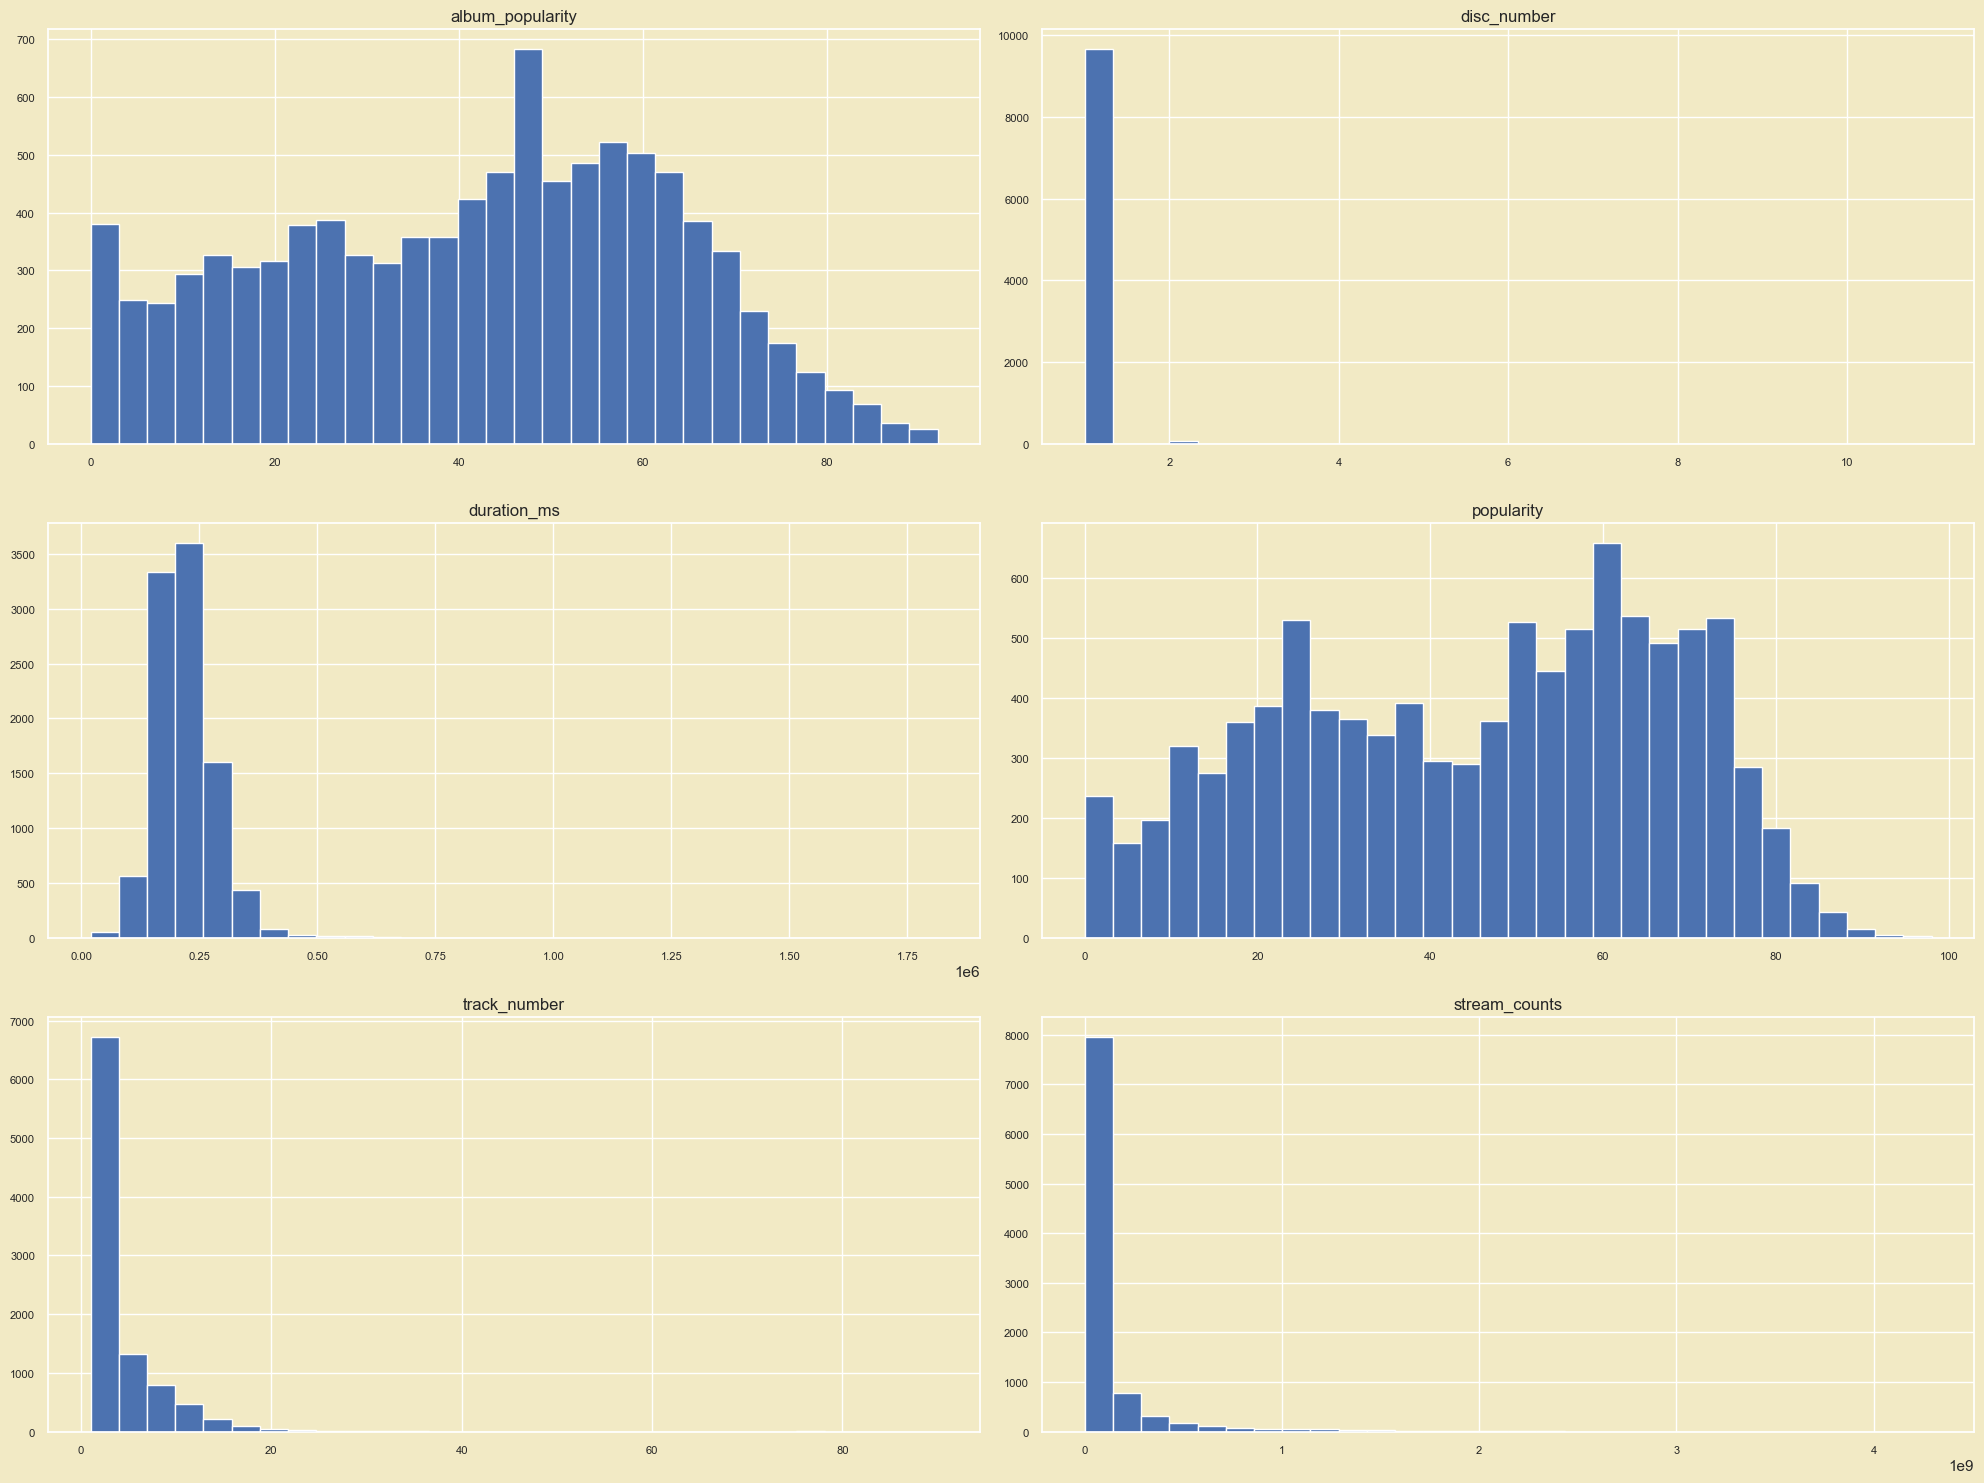

In [22]:
import seaborn as sns  
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols_tracks.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

1. **Album Popularity**: This distribution appears somewhat right-skewed, with most albums having a popularity score between 20 and 70, peaking around 40.

2. **Disc Number**: The vast majority of songs belong to the first disc (disc number = 1), with very few instances for higher disc numbers.

3. **Duration (ms)**: This is highly right-skewed, meaning most songs have a relatively short duration, with only a few significantly longer ones.

4. **Popularity**: This distribution looks similar to "album_popularity," with a peak around 40-60 and a gradual decrease toward the extreme ends.

5. **Track Number**: This is heavily right-skewed, indicating that most albums have only a few tracks, while some contain a much larger number of songs.

6. **Stream Counts**: The majority of songs have low stream counts, with a few highly streamed outliers.

However, to have a better visualization of skewed data, we will use `log_transform`.

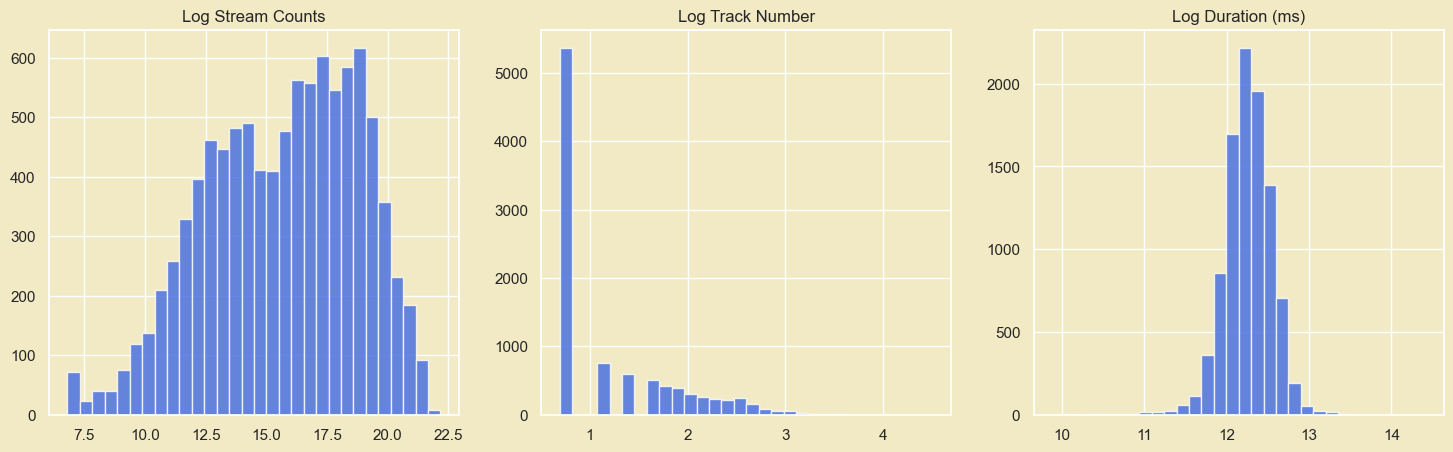

In [23]:
song_copy = song_df.copy()
song_copy['log_stream_counts'] = np.log1p(song_copy['stream_counts'])  # log(1 + x) to handle zeros
song_copy['log_track_number'] = np.log1p(song_copy['track_number'])
song_copy['log_duration_ms'] = np.log1p(song_copy['duration_ms'])

# Plot histograms for the log-transformed features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ['log_stream_counts', 'log_track_number', 'log_duration_ms']
titles = ['Log Stream Counts', 'Log Track Number', 'Log Duration (ms)']

for ax, feature, title in zip(axes, features, titles):
    ax.hist(song_copy[feature], bins=30, color='royalblue', alpha=0.8)
    ax.set_title(title)
    ax.grid(True)

plt.show()

1. **Log Stream Counts (Left Plot):**

    - The distribution appears approximately normal after the log transformation.
    - The transformation successfully reduces the skewness and makes the data more symmetric.
    - The peak is around 17-20, suggesting that most songs have moderate to high stream counts.

2. **Log Track Number (Middle Plot):**

    - Even after log transformation, the distribution remains highly skewed, with a significant number of tracks having very low values (likely track number = 1).
    - This suggests that most albums or playlists have only a few tracks, with very few having a high track count.

3. **Log Duration (Right Plot):**

    - The transformation has effectively normalized the duration distribution, making it more Gaussian.
    - The peak around 12-13 suggests that most songs have a duration between e^12 (~162,000 ms or ~2.7 minutes) and e^13 (~440,000 ms or ~7.3 minutes).
    - The transformation minimizes the effect of extremely long tracks.

#### Artists Dataset

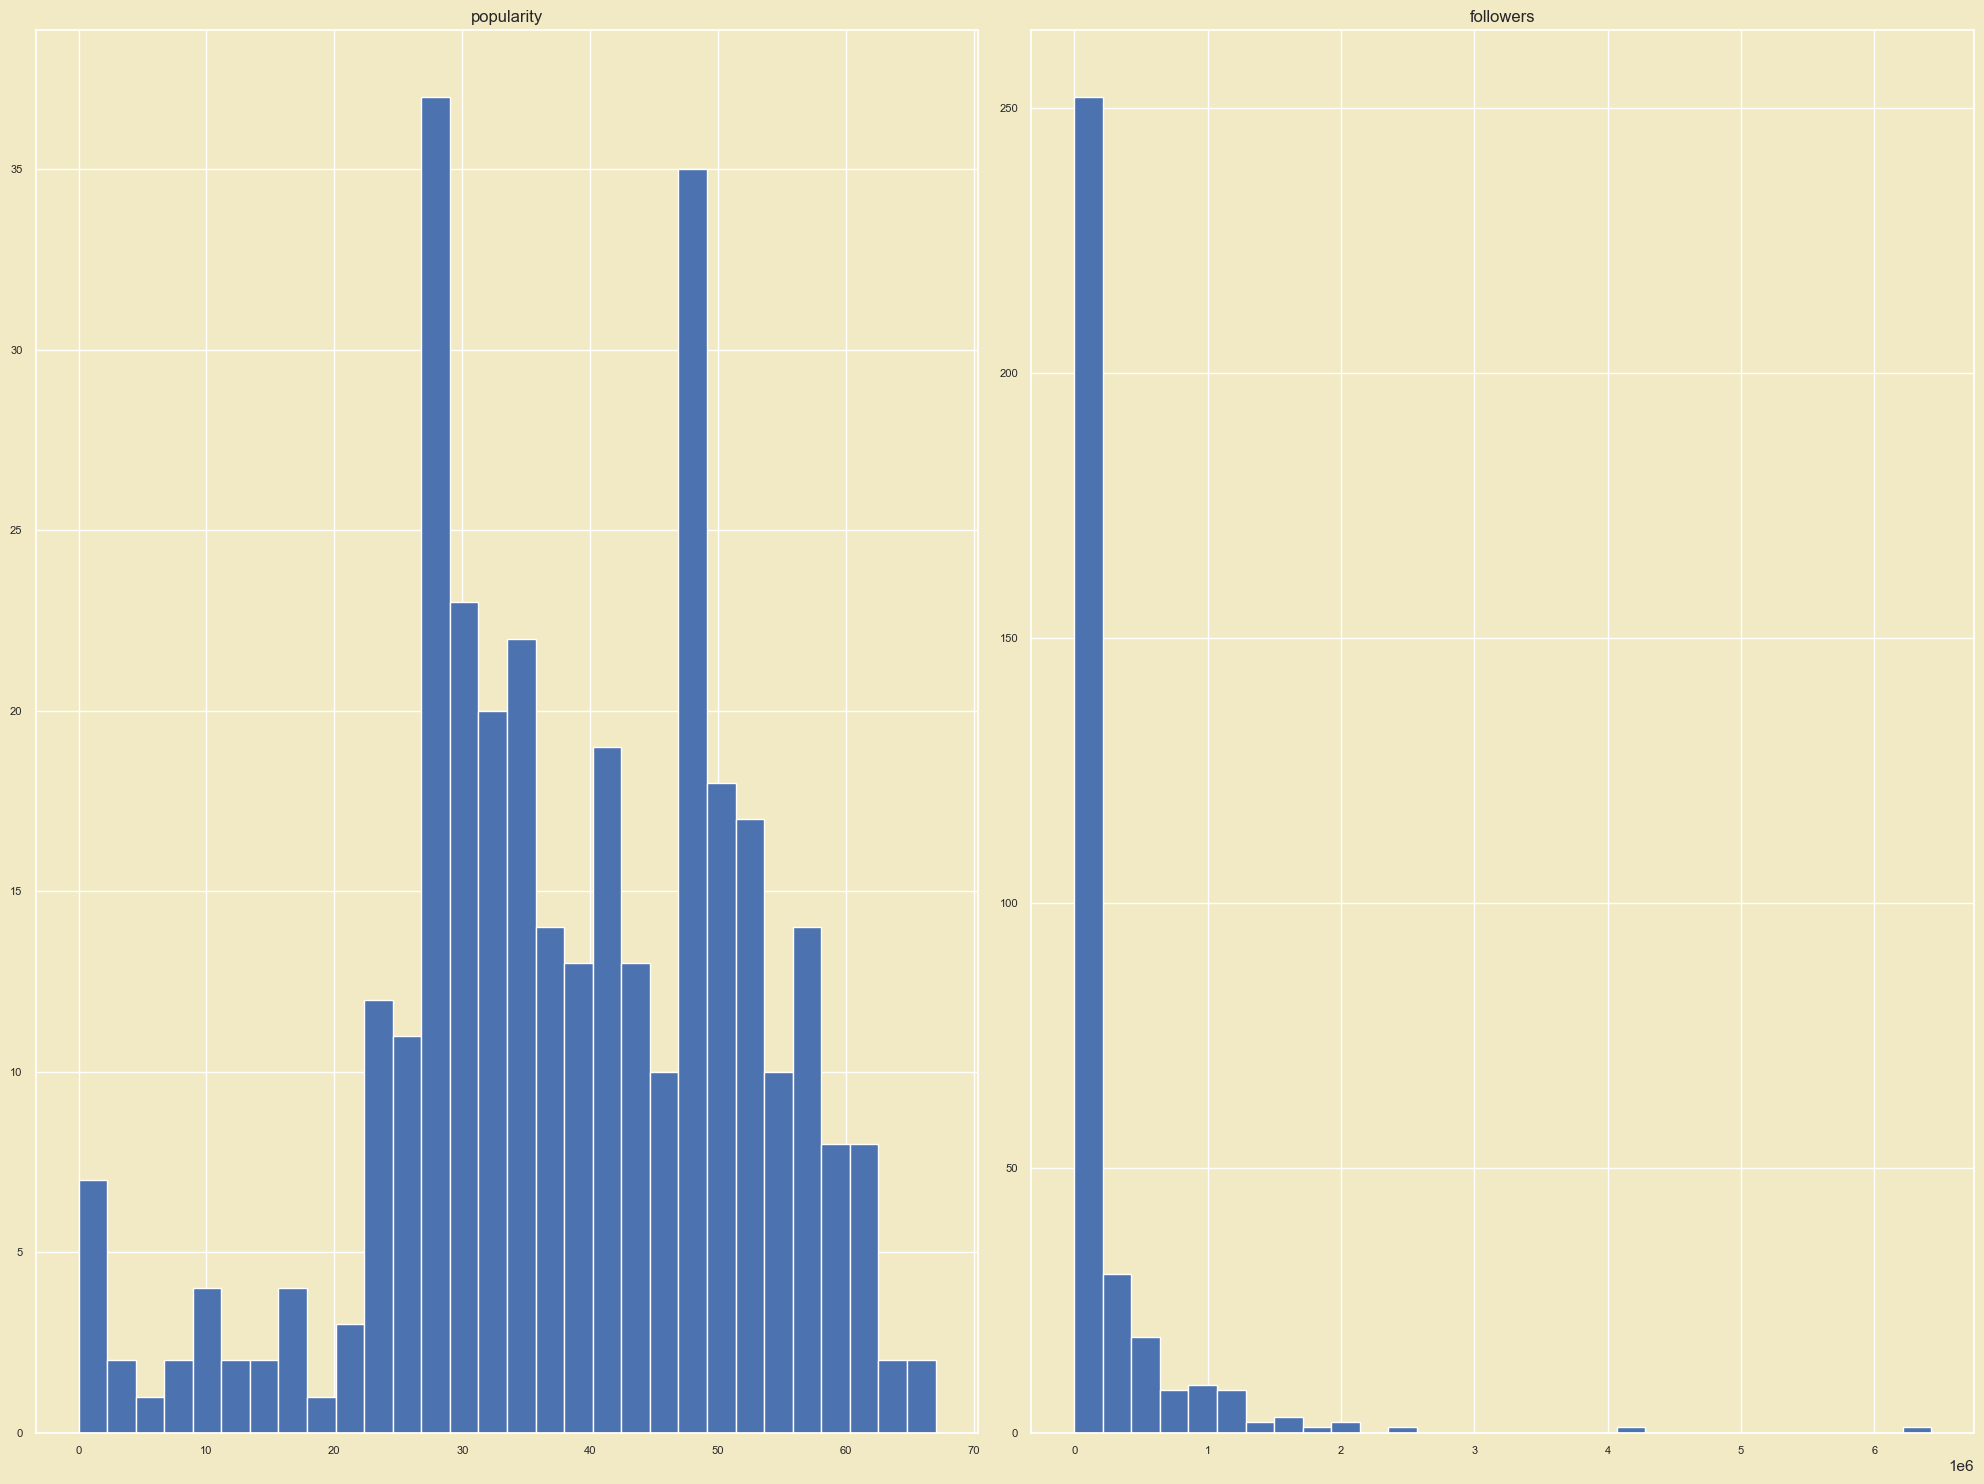

In [24]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols_artists.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

1. **Popularity:**

    - The popularity values range from 0 to around 70.
    - The distribution appears to be right-skewed, meaning there are more artists with lower popularity.
    - Peaks around 30-40 and 50-60 suggest that artists tend to cluster in these ranges.

2. **Followers:**

    - The number of followers varies widely, spanning from close to 0 to over 6 million.
    - There is a high concentration of artists with very few followers.
    - A small number of artists have an extremely high number of followers, leading to a long tail in the distribution.

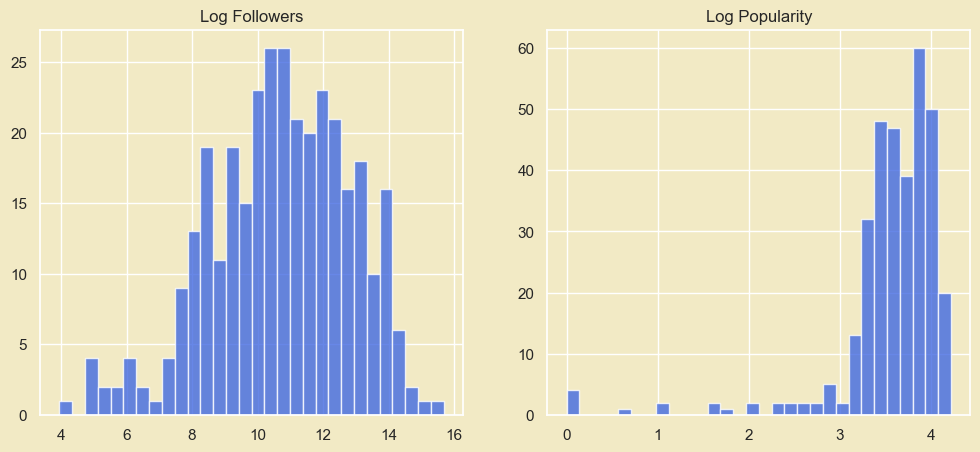

In [25]:
vn_artists_copy = vn_artists.copy()
vn_artists_copy['log_followers'] = np.log1p(vn_artists_copy['followers'])  # log(1 + x) to handle zeros
vn_artists_copy['log_popularity'] = np.log1p(vn_artists_copy['popularity'])

# Plot histograms for the log-transformed features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
features = ['log_followers', 'log_popularity']
titles = ['Log Followers', 'Log Popularity']

for ax, feature, title in zip(axes, features, titles):
    ax.hist(vn_artists_copy[feature], bins=30, color='royalblue', alpha=0.8)
    ax.set_title(title)
    ax.grid(True)

plt.show()

1. **Log Followers**
    - The distribution now appears closer to a normal shape, meaning the raw data was heavily skewed.
    - Most values are concentrated between log(8) and log(13), meaning most artists have followers in the range of 10⁸ to 10¹³.
2. **Log Popularity**
    - The distribution shows two clear peaks around log(3.5) and log(4.0), meaning many artists have popularity values around 30-50 in linear scale.
    - Some low-popularity artists remain but are now more visible.

<a class="anchor" id="2.2.2."></a>
<h5 style="text-align: left; background-color:rgb(35, 159, 225); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.2.2. Categorical columns </b></h5>

- First we get all categorical columns

In [26]:
categorical_cols = song_df[song_df.columns[(song_df.dtypes == 'object') | (song_df.dtypes == 'bool')]]
categorical_cols.columns

Index(['album', 'album_type', 'artists', 'explicit', 'id', 'name', 'genres'], dtype='object')

We have 7 categorical columns

- Examine the percentage of missing values for each column again

In [27]:
missing_vals = pd.DataFrame(
    data={
        'missing_values': categorical_cols.isnull().sum(),
        'missing_percentage': categorical_cols.isnull().mean() * 100
    }
)
missing_vals

,missing_values,missing_percentage
album,0,0.0
album_type,0,0.0
artists,0,0.0
explicit,0,0.0
id,0,0.0
name,0,0.0
genres,0,0.0


- Since `genres` and `artists` are list type therefore we will need to check if there is empty list or not

In [28]:
# Get the count of [] in genres and artists columns
empty_genres = len(song_df[song_df['genres'].apply(lambda x: isinstance(x, list) and len(x) == 0)])
empty_artists = len(song_df[song_df['artists'].apply(lambda x: isinstance(x, list) and len(x) == 0)])
print("Number of songs without genres: ", empty_genres)
print("Number of songs without artists: ", empty_artists)

Number of songs without genres:  473
Number of songs without artists:  0


In [29]:
# Check rows with empty genres
song_df[song_df['genres'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

,album,album_type,album_popularity,artists,disc_number,duration_ms,explicit,id,name,popularity,track_number,release_date,genres,stream_counts
45,Shut up My Moms Calling,single,72,[Hotel Ugly],1,164571,False,3hxIUxnT27p5WcmjGUXNwx,Shut up My Moms Calling,82,1,2020-02-10,[],1.231206e+09
50,Камин (feat. JONY),single,58,"[EMIN, JONY]",1,187619,False,057YRaQ57p70MVg4hMIIkB,Камин (feat. JONY),68,1,2020-03-27,[],6.303045e+07
55,Color,single,64,[Coyote Theory],1,242010,False,79EkGysjP2dL5GdpeQjRxT,This Side of Paradise,75,3,2020-12-11,[],6.029918e+08
101,M.,single,58,[Anıl Emre Daldal],1,223750,False,6wfb4nI2Vih263JqC8WSoW,M.,68,1,2020-12-04,[],1.909688e+08
139,Blue Jeans,single,57,[GANGGA],1,211483,False,4kfjA6WfgKBt7I7YKuDCkU,Blue Jeans,67,1,2020-06-05,[],2.855547e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,Rise of a Warrior,single,2,[vSØUL],1,193879,False,2FSSmS7EQANK2q89AFLWiU,Rise of a Warrior,7,1,2025-01-03,[],9.000000e+02
9111,Rain in My City 2,album,54,"[Billionaire Swagger, Pcb Butter]",1,146259,True,1DW4krhPbDDrwSOpxMHiVf,Ape Shit,41,7,2020-02-08,[],6.110600e+04
9112,know this,single,4,[PCKL],1,221728,False,4YaQ2EJwhnRl4hU1bS7Lsw,know this,10,1,2023-06-06,[],1.541800e+04
9717,Undiscovered Land,album,0,[Samuel Liu],1,1315680,False,3Ma6FipGlFRSMMewJFqHcK,Fields of Grace - Entering In,0,8,2019-01-24,[],9.000000e+02


In [30]:
# Get the name of artist with empty genres
empty_artists = song_df[song_df['genres'].apply(lambda x: isinstance(x, list) and len(x) == 0)]
empty_artists['artists']

45                           [Hotel Ugly]
50                           [EMIN, JONY]
55                        [Coyote Theory]
101                    [Anıl Emre Daldal]
139                              [GANGGA]
                      ...                
8943                              [vSØUL]
9111    [Billionaire Swagger, Pcb Butter]
9112                               [PCKL]
9717                         [Samuel Liu]
9718                          [Grace Liu]
Name: artists, Length: 473, dtype: object

In [31]:
# palette = viridis, coolwarm, magma, pastel, deep
def categorical_columns_plot(df, column_name, split_values=True, n_top=10, palette="magma", title='', xlabel = '', ylabel = ''):
    if split_values:
        all_values = df[column_name].fillna('')
        
        all_values = all_values.explode()
        all_values = all_values[all_values != '']
        
        unique_values = all_values.value_counts()
    else:
        unique_values = df[column_name].value_counts()
    
    plt.figure(figsize=(12, 6))
    plot_data = unique_values.head(n_top)
    
    colors = sns.color_palette(palette, min(len(plot_data), 10))
    
    plt.barh(y=range(len(plot_data)), width=plot_data.values, color=colors, edgecolor='black', linewidth=1.5)
    plt.yticks(range(len(plot_data)), plot_data.index)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def pie_plot(df, column_name, colors = ['lightcoral','lightblue', 'lightgreen'], title = '', ylabel = ''):
    plt.figure(figsize=(8,8))
    df[column_name].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

**ID** and **Name**

+ Each song have it own ID and Name. Songs might have the same name but the ID are unique

In [32]:
len(categorical_cols['id'].unique())

9719

+ There are 9719 IDs for 9719 song

**Albums** and **Album Type**:

In [33]:
n_album = len(categorical_cols['album'].unique())
print(f'Number of different albums : {n_album}')

Number of different albums : 7092


+ There are 7092 different albums accross 9719 songs

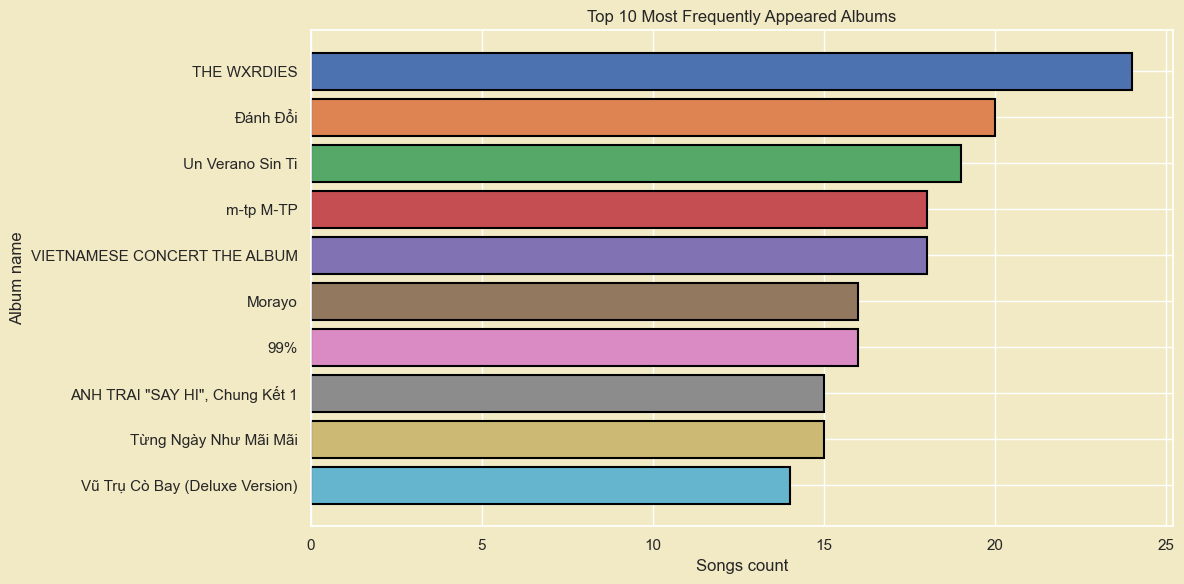

In [34]:
categorical_columns_plot(categorical_cols, column_name='album', 
                         split_values=False,
                         title='Top 10 Most Frequently Appeared Albums',
                         xlabel='Songs count',
                         ylabel='Album name',
                         palette='deep')
                        

In [35]:
categorical_cols['album_type'].value_counts()

album_type
single         5688
album          3760
compilation     271
Name: count, dtype: int64

+ There are 3 types of albums:
    + Single : Usually a single track in this 
    + Album : Usually contains multiple songs of a artist
    + Compilation : Usually a collection of songs (with many artists)

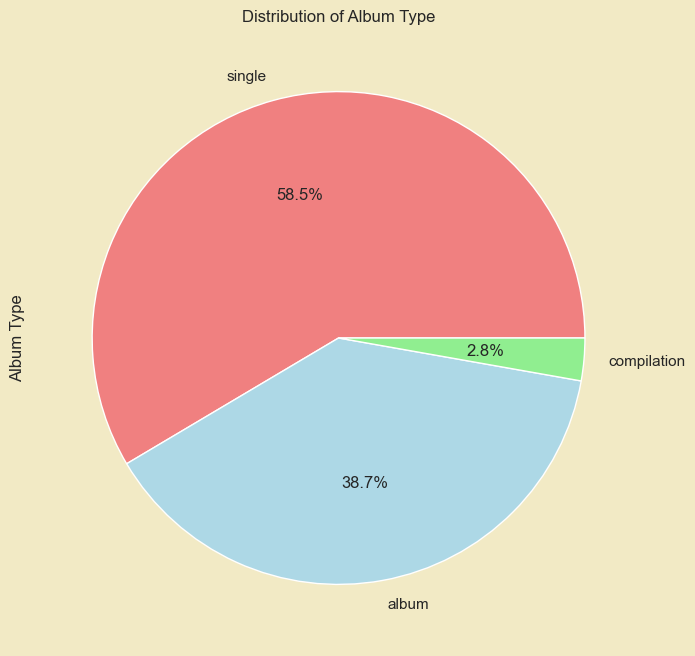

In [36]:
pie_plot(categorical_cols, column_name='album_type',
         title='Distribution of Album Type',
         ylabel='Album Type')

+ We can see that more than half of the album type are Single, which contain 1 song each

**Explicit**

An explicit track is one that has curse words or language or art that is generally deemed sexual, violent, or offensive in nature

In [37]:
categorical_cols['explicit'].value_counts()

explicit
False    8048
True     1671
Name: count, dtype: int64

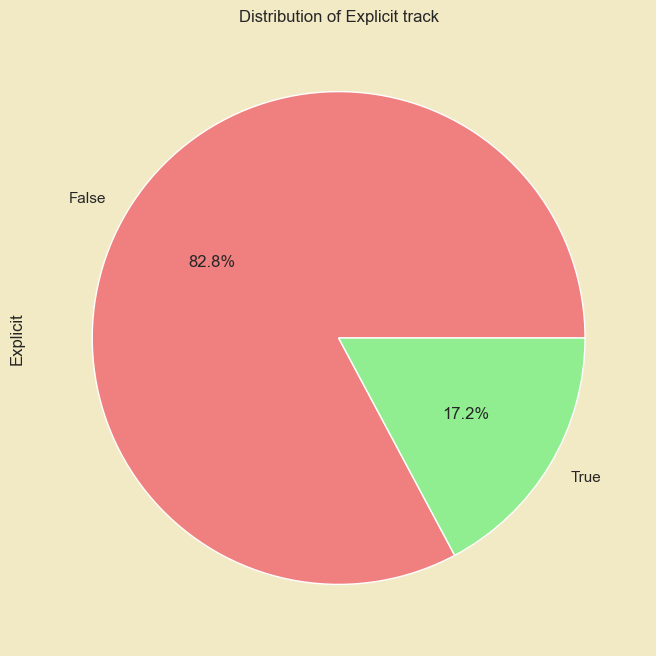

In [38]:
pie_plot(categorical_cols, column_name='explicit',
         title = 'Distribution of Explicit track',
         ylabel='Explicit',
         colors=['lightcoral','lightgreen'])

Only 17.2% of the songs are marked explicit, which means the majority of the songs have clean lyrics suitable for all audiences.

**Artists**

+ Each songs might have 1 or more artists.

In [39]:
n_artists = len(list(set(np.sum(categorical_cols['artists']))))
print(f"There are total {n_artists} artists in the dataset")

There are total 5291 artists in the dataset


+ We find top 10 artists that produce most songs (or appeared in most songs)

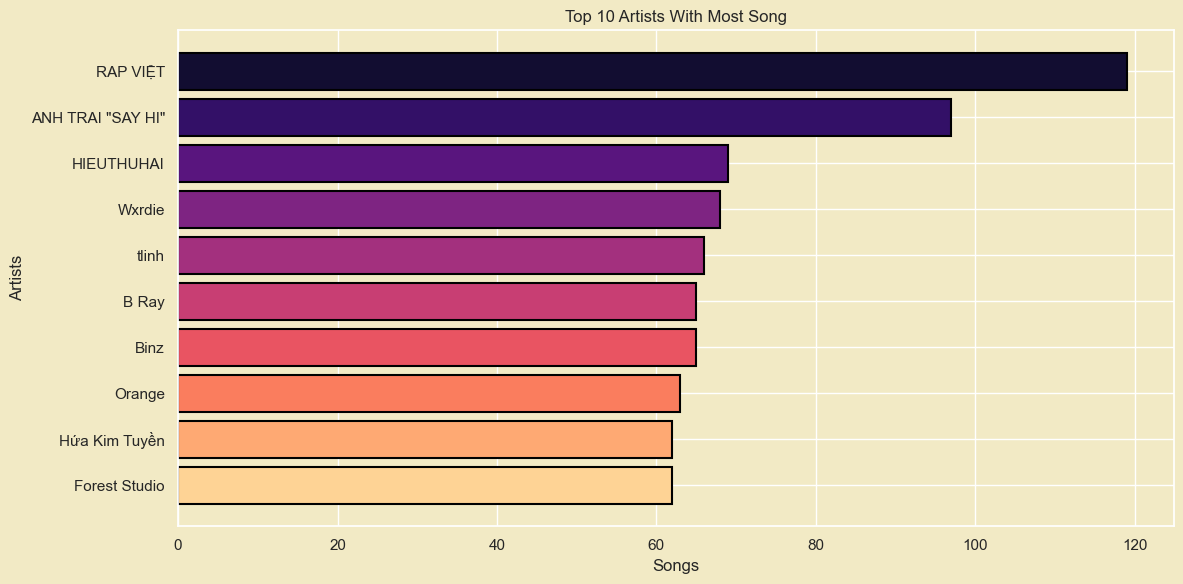

In [40]:
categorical_columns_plot(categorical_cols, column_name='artists',
                         title = 'Top 10 Artists With Most Song',
                         xlabel='Songs',
                         ylabel='Artists',
                         palette='magma',
                         split_values=True)

+ We can see that some famous Vietnamese artists, such as HIEUTHUHAI, B Ray, and Binz, are on the list, each having distributed or collaborated on between 60 and 120 songs. Too bad Son Tung MTP is not on the list.

**Genres**

+ Since spotify dont really provide a specific genre for a song, therefore a song genres is determined by it's producer. If a song is created through a collaboration of artists, its genre is a combination of the genres of those artists.

In [41]:
n_genres = len(list(set(np.sum(categorical_cols['genres']))))
print("Total number of different genres: ", n_genres)

Total number of different genres:  1016


+ There are total of 1016 different genres accross 9719 songs
+ The genres are independently crawled from the Spotify API, GetGenre, and Brainz.

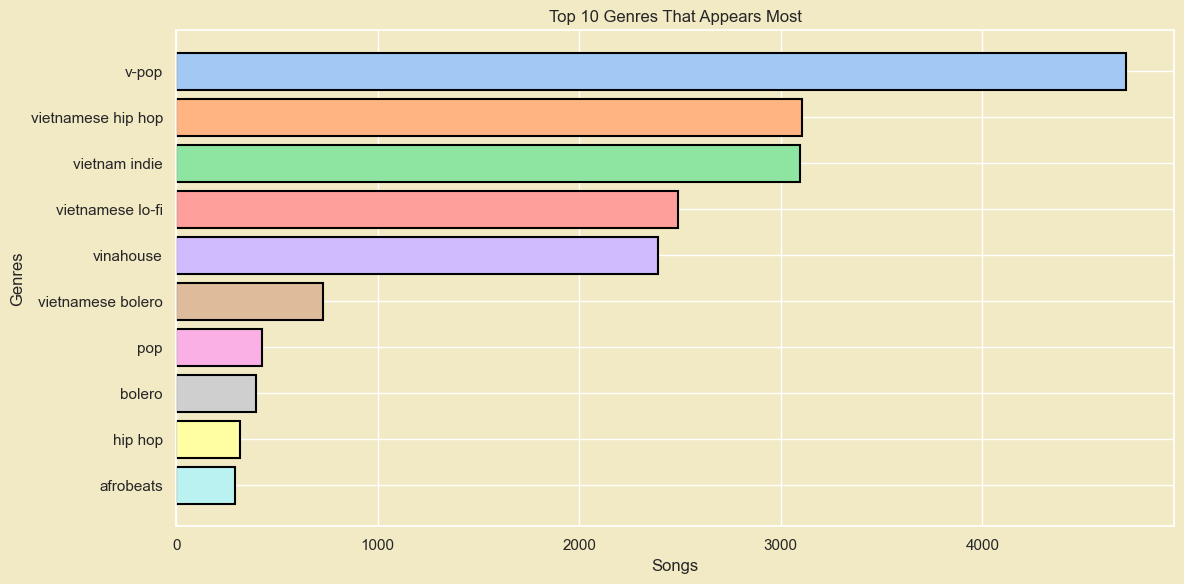

In [42]:
categorical_columns_plot(categorical_cols, column_name='genres',
                         title = 'Top 10 Genres That Appears Most',
                         xlabel='Songs',
                         ylabel='Genres',
                         palette='pastel',
                         split_values=True)

+ In this dataset, we can see that a lot of the songs are Vietnamese songs, with more than 4000 songs are Vietnamese pop music (v-pop)
+ Followed by Vietnamese hip-hop, indie, lo-fi, and bolero, which also have a significant presence in the dataset.

<a class="anchor" id="2.3."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.3. Abnormal values and outliers</b></h4>

To check abnormals and outliers of 2 datasets, we will use boxplot to visualize the outliers of each column

#### Tracks Dataset


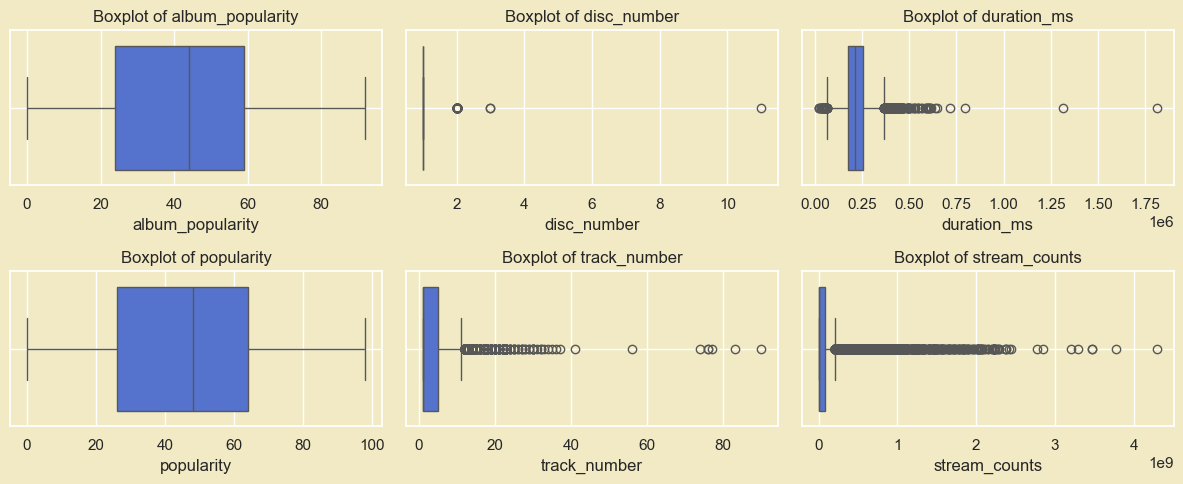

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i, col in enumerate(numerical_cols_tracks.columns):
    sns.boxplot(x=col, data=song_df, ax=axes[i//3, i%3], color='royalblue')
    axes[i//3, i%3].set_title(f"Boxplot of {col}")
    axes[i//3, i%3].grid(True)
plt.tight_layout()
plt.show()

- `album_popularity` and `popularity` don’t really have any significant outliers.
- However, `disc_number`, `duration_ms`, `track_number`, and `stream_counts` have quite a few extreme values. But that’s expected since these are continuous variables with a wide range and don’t follow a normal distribution. Things like album structure, song length, and streaming numbers naturally vary a lot. So, rather than removing these outliers, it makes sense to keep them since they reflect the real diversity in music data.

#### Artists Dataset

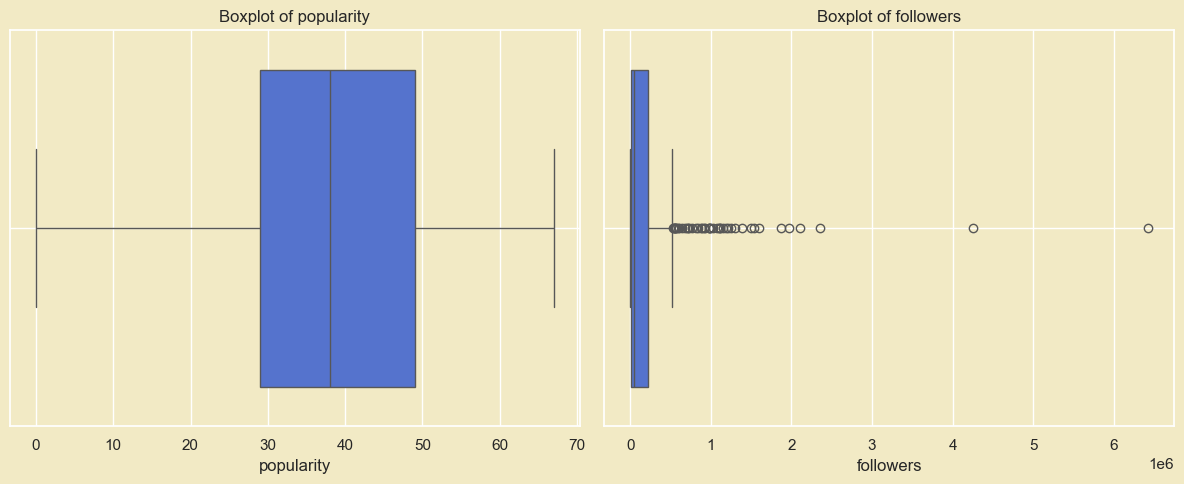

In [49]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
num_cols = len(numerical_cols_artists.columns)
fig, axes = plt.subplots(1, num_cols, figsize=(12, 5))

for i, col in enumerate(numerical_cols_artists.columns):
    sns.boxplot(x=col, data=vn_artists, ax=axes[i], color='royalblue')
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

- `popularity` looks well distributed with no extreme outliers. The values range from 0 to around 70, with most data falling within a reasonable range.
- `followers`, on the other hand, has a lot of outliers, especially at the higher end. A few artists have an extremely high number of followers compared to the rest, which is expected in the music industry where a small number of top artists dominate in terms of fanbase. These outliers in followers make sense and should probably be kept since they reflect the real-world distribution of artist popularity.

<a class="anchor" id="2.4."></a>
<h4 style="text-align: left; background-color:rgb(36, 138, 193); font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>2.4. Correlation between variables</b></h4>

We will use `heatmap` to check the correlation between numerical features of each dataset

#### Tracks Dataset

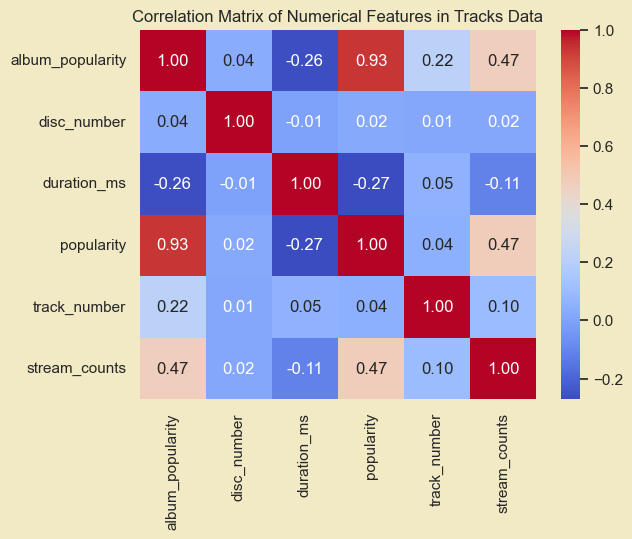

In [50]:
sns.heatmap(numerical_cols_tracks.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features in Tracks Data")
plt.show()


1. **Strong Positive Correlation:**

    - `album_popularity` and `popularity` (0.93): This makes sense as popular albums tend to have popular tracks.
    - `album_popularity` and `stream_counts` (0.47): More popular albums generally receive more streams.

2. **Moderate Positive Correlation:**

    - `popularity` and `stream_counts` (0.47): Popular songs tend to have more streams, though other factors may also influence stream counts.
    - `track_number` and `album_popularity` (0.22): Albums with more tracks might be slightly more popular, but the correlation is not strong.

3. **Negative Correlations:**

    - `duration_ms` and `album_popularity` (-0.26): Longer tracks may not necessarily be more popular, possibly because shorter songs are more replayable.
    - `duration_ms` and `popularity` (-0.27): Similar to the previous point, shorter tracks might be more engaging for listeners.

4. **Weak or No Correlation:**

    - `disc_number` does not show significant correlation with any other variables, suggesting that the number of discs in an album does not impact track popularity or streaming numbers.

#### Artists Dataset

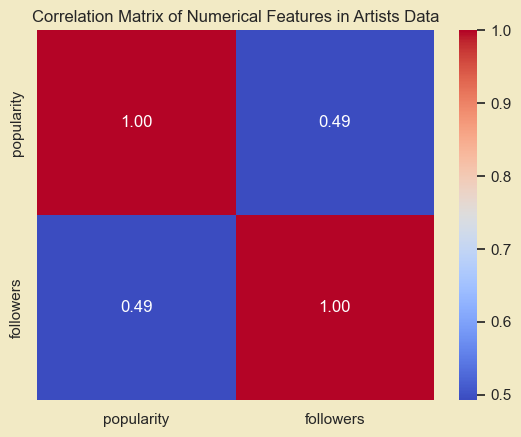

In [51]:
sns.heatmap(numerical_cols_artists.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features in Artists Data")
plt.show()


- **Popularity and Followers Correlation (0.49):**
    - There is a moderate positive correlation (0.49) between an artist's popularity and their number of followers.
    - This suggests that while more followers generally indicate a more popular artist, it's not a perfect relationship. Some artists may have many followers but not rank high in popularity (perhaps due to inactive listeners or older fan bases), while others may be highly popular due to viral hits but have fewer long-term followers.